
# Scotiabank Annual Release Reports: Instant Analysis and Translation Powered by Custom Made Chatbot


This is a cutting-edge chatbot designed to analyze Annual reports (+200 pages) with ease. Where users can receive instant, detailed answers to their queries. Leveraging advanced natural language processing, this chatbot provides real-time insights and translations of complex financial data. This tool simplifies financial analysis, making critical information more accessible and understandable.

Source: https://www.scotiabank.com/content/dam/scotiabank/corporate/quarterly-reports/2024/q4/Annual_Report_2024_English.pdf

## Team Alpha

* Raemil Corniel
* Uma Maheshwari
* Jharana Adhikari
* Yasaswin Palukuri


Table of Content
0.  Install libraries needed to run the notebook
1.  Load Libraries
2.  Class and functions
3.  Load data
4.  Analysis data (before cleaning)
5.  Clean data
6.  Exploratory Data Analysis
7.  Modeling
> * I.  Load library and dataset
  * II. Define metrics functions
  * III. Bert (bert-base-uncased) and Metrics
  * IV. GPT and Metrics
  * V. Translations and Metrics
9. Conclusion






### 0. Install libraries needed to run the notebook

In [113]:
pip install bert_score

In [114]:
pip install langchain langchain-community llama-cpp sentence-transformers faiss-cpu


ERROR: Could not find a version that satisfies the requirement llama-cpp (from versions: none)
ERROR: No matching distribution found for llama-cpp


In [115]:
pip install langchain_community

In [116]:
pip install faiss-cpu

In [117]:
pip install llama-cpp-python


In [118]:
pip install evaluate sacrebleu

In [119]:
pip install datasets wandb

In [120]:
pip install tabula-py pypdf PdfReader pdfminer pdfminer.six jpype1


In [121]:
pip install rouge-score fuzzywuzzy langdetect langid transformers torch sentence_transformers


In [122]:
pip install rouge-score

### 1. Load Libraries

In [123]:
import pandas as pd
import re
import math

from pypdf import PdfReader
from pdfminer.converter import TextConverter
from pdfminer.pdfdocument import PDFDocument
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.pdfpage import PDFPage
from pdfminer.pdfparser import PDFParser
from pdfminer.layout import LAParams
from pdfminer.high_level import extract_text

import io
import tabula
import jpype

from bs4 import BeautifulSoup

import wordcloud
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns


import nltk

from nltk import FreqDist
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.util import ngrams
from collections import Counter


In [124]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [125]:
#show all columns in a df
pd.set_option('display.max_columns', None)
#show full row info
pd.set_option('display.max_colwidth', None)

In [126]:
print("JPype version:", jpype.__version__)


JPype version: 1.5.2


### 2. Classes and Function
#### This is to avoid code repetition and for code clarity and reusability  

In [ ]:
#load file, given a pdf file path
def load_file(pdf):
    #load the file
    document = PdfReader(pdf , 'rb')

    counter=0
    textList = []

    # only read first 11 pages the last 3 pages are not relevant (Forward-looking statements, Shareholders Information)
    while counter < (len(document.pages) -3):
        pageObj = document.pages[counter]

        textList.append(pageObj.extract_text())
        counter += 1

    #return a list with the pages of the document, this list does not contain tables only textual info
    return textList


In [ ]:
#clean text from html tags, \n, extra spaces, urls, double spaces , lower case
def clean_text(fileText):

    #clean file text
    textCleannedList = []
    for textToProccess in fileText:
        #lower case
        textToProccess = textToProccess.lower()

        #remove all tags from html
        textToProccess= BeautifulSoup(textToProccess, 'html.parser').get_text()

        #remove newlines
        textToProccess= textToProccess.replace('\n',' ')

        #remove spaces
        textToProccess = textToProccess.strip()

        #remove urls
        patterns = re.compile(r'https?://\S+|www\.\S+')
        textToProccess = patterns.sub(' ', textToProccess)

        #remove double space
        textToProccess =re.sub("\s\s+" , " ", textToProccess)

        textCleannedList.append(textToProccess)

    return textCleannedList

# clean text for questioning
def clean_text_question(text):
    # Remove special characters
    text = re.sub(r'[^\w\s]', '', text)

    # Normalize case
    text = text.lower()

    # Remove extra whitespace
    text = ' '.join(text.split())

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    words = text.split()
    cleaned_text = ' '.join([word for word in words if word.lower() not in stop_words])
    return cleaned_text

In [ ]:
#get text from specific part of the document
#given a list of pages, start word, end word , and a tag for identifying type of information extracted
def extract_text_between_words_across_pages(text_pages, start_word, end_word, tag):
    extracted_texts = []
    #join all pages
    combined_text = "\n".join(text_pages)
    pattern = re.compile(re.escape(start_word) + '(.*?)' + re.escape(end_word), re.S)

    for match in pattern.finditer(combined_text):
        start_page, end_page = None, None
        start_index, end_index = match.start(), match.end()

        cumulative_length = 0
        for i, page in enumerate(text_pages):
            page_length = len(page)
            if start_page is None and start_index < cumulative_length + page_length:
                start_page = i + 1
            if end_page is None and end_index <= cumulative_length + page_length:
                end_page = i + 1
            cumulative_length += page_length + len("\n")
            if start_page is not None and end_page is not None:
                break

        extracted_texts.append({
            'start_page': start_page,
            'end_page': end_page,
            'start_word': start_word,
            'end_word': end_word,
            'tag':tag,
            'extracted_text': start_word +' '+ match.group(1).strip()
        })
    return extracted_texts

In [ ]:
#given a list of pages, and  list of set of words (start, end) return a list of findings
def process_files_in_folder(text_pages, start_end_pairs, tag):
    all_extracted_texts = []

    for start_word, end_word in start_end_pairs:
        extracted_texts = extract_text_between_words_across_pages(text_pages, start_word.lower(), end_word.lower(),tag)
        all_extracted_texts.extend(extracted_texts)

    return all_extracted_texts


In [ ]:

# Function to add dollar sign to numeric values
def add_dollar_sign(value):
    if isinstance(value, str) and value.replace(',', '').isdigit():
        return f'${value}'

    if isinstance(value, str) and '-' in value:
        return f'${value}'

    return value


# Define the function to convert values
def add_dollar_negative_sign(value):
    if isinstance(value, str):
        # Check if the value is in parentheses
        match = re.match(r'\(([\d,]+)\)', value)
        if match:
            # Extract the number, convert to negative, and format with dollar sign
            number = match.group(1).replace(',', '')
            return f'${-int(number):,}'
    return value




# Function to create new column names
def add_headers(df,numColJoin):
    new_columns = []
    for col in df.columns:
       # Join the first 3 rows for this column
       if 'Unnamed' in col:
          joined_name = ' '.join(df[col].iloc[:numColJoin].dropna().astype(str))
       else:
          joined_name =  col + ' ' + ' '.join(df[col].iloc[:numColJoin].dropna().astype(str))

       new_columns.append(joined_name)

    return new_columns


# Function to clean column names from (number) and .number
def remove_number_header(name):
    # Remove patterns like (number) and .number
    cleaned_name = re.sub(r'\(\d+\)', '', name)  # Remove (number)
    cleaned_name = re.sub(r'\.\d+', '', cleaned_name)  # Remove .number
    return cleaned_name.strip()



#if any row has double text then join them
def join_row_double_text(df):
    rows = []

    for i in range(len(df)):
        if df.iloc[i, 0] == 'Adjustments:':
          continue


        if i > 0 and df.iloc[i-1][1:].isna().all():

            # Previous row is all NaN, current row contains values
            merged_name = df.iloc[i-1, 0] + ' ' + df.iloc[i, 0] if not pd.isna(df.iloc[i, 0]) else df.iloc[i-1, 0]
            # Create a new row with merged column name and current row's values
            new_row = [merged_name] + list(df.iloc[i, 1:])
            rows.append(new_row)
        else:
            # Normal row, just add it
            rows.append(df.iloc[i].tolist())

    # Create a new DataFrame from the rows
    result_df = pd.DataFrame(rows, columns=df.columns)

    return result_df


# Function to split DataFrame based on specific text
def split_dataframe_on_text(df, text, check_columns):
    split_indices = []
    tables = []

    # Track the start of the current table
    start_idx = 0

    for i in range(len(df)):
        row = df.iloc[i]
        # Check if column 0 is NaN or null
        if pd.isna(row[0]):
            # Check other specified columns for the text
            found = any(text in str(row[col]) for col in check_columns)
        else:
            # Check if the text is in column 0
            found = text in str(row[0])

        # If the text is found, add the index to the split_indices list
        if found:
            # Check if this row contains the specified text
            if i > start_idx:
                split_indices.append(i)
                tables.append(df.iloc[start_idx:i])
                start_idx = i
    # Append the last segment
    if start_idx < len(df):
        tables.append(df.iloc[start_idx:])

    return tables


def split_dataframe_on_text_column(df, text, check_column):
    split_indices = []
    tables = []

    # Track the start of the current table
    start_idx = 0

    for i in range(len(df)):
        row = df.iloc[i]
        # Check if column 0 is NaN or null
        found = text in str(row[check_column])

        # If the text is found, add the index to the split_indices list
        if found:
            # Check if this row contains the specified text
            if i > start_idx:
                split_indices.append(i)
                tables.append(df.iloc[start_idx:i])
                start_idx = i
    # Append the last segment
    if start_idx < len(df):
        tables.append(df.iloc[start_idx:])

    return tables


# Function to split rows with multiple values
def split_rows(df):
    new_rows = []
    for index, row in df.iterrows():
        # Check for rows with space-separated values
        for col in df.columns:
            if isinstance(row[col], str) and ' ' in row[col]:
                # Split the cell content by space
                split_values = row[col].split()
                # If there are more than 2 values, handle them
                if len(split_values) > 1:
                    # Create new rows based on split values
                    for i in range(len(split_values)):
                        new_row = row.copy()
                        new_row[col] = split_values[i]
                        new_rows.append(new_row)
                else:
                    new_rows.append(row)
            else:
                new_rows.append(row)

    # Create a new DataFrame with the expanded rows
    return pd.DataFrame(new_rows)

def remove_dollar_sign(df):
    # Define a function to process each cell
    def remove_dollar_sign_from_cell(cell):
        if isinstance(cell, str) and cell.endswith('$'):
            # Remove the dollar sign from the end of the string
            return cell.rstrip('$')
        return cell

    # Apply the function to each cell in the DataFrame
    return df.applymap(remove_dollar_sign_from_cell)





### 3. Load data



> In this step the data will be load twice, once using the library pypdf for gather all the text of the report, and using tabula, this library will help us load all the tables of the report in a more propper format.



In [ ]:
#load file from google drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# load report file from gogle drive
pdf_path = "/content/drive/My Drive/Annual_Report_2024_English.pdf"

#get file text , provide pdf path
file_text = load_file(pdf_path)

# Extract all tables from the PDF
tables = tabula.read_pdf(pdf_path, pages='all', multiple_tables=True)



#indicate the quater and year
quater= 'Annua'
year = '2024'

### 4. Analysis of the data (before cleaning)

In [ ]:
#len of the document
print('Total pages', len(file_text))


#words per page
for index , page in enumerate(file_text):
    words_per_page = len(page.split())
    print(f'Total words per  page #{index} :{ words_per_page}')

#amount of words in the document
total_words = sum(len(page.split()) for page in file_text)
print('\nTotal Words:', total_words)



print(f'Total tables available: {len(tables)}')


Total pages 233
Total words per  page #0 :3
Total words per  page #1 :236
Total words per  page #2 :238
Total words per  page #3 :274
Total words per  page #4 :495
Total words per  page #5 :442
Total words per  page #6 :283
Total words per  page #7 :388
Total words per  page #8 :255
Total words per  page #9 :260
Total words per  page #10 :368
Total words per  page #11 :122
Total words per  page #12 :526
Total words per  page #13 :349
Total words per  page #14 :414
Total words per  page #15 :227
Total words per  page #16 :326
Total words per  page #17 :642
Total words per  page #18 :310
Total words per  page #19 :1159
Total words per  page #20 :701
Total words per  page #21 :715
Total words per  page #22 :795
Total words per  page #23 :789
Total words per  page #24 :591
Total words per  page #25 :462
Total words per  page #26 :658
Total words per  page #27 :466
Total words per  page #28 :979
Total words per  page #29 :960
Total words per  page #30 :305
Total words per  page #31 :559
Tot



> The financial Annual Release report of Scotiabank has ~236 pages, all the pages has been taken for analysis, since everything provides usefull information to the user



*   Total pages 236
*   Total Words: 161605
*   Tables: 215


















In [ ]:
#show a few pages of the report
#since our array start at 0 and report counting pages start a page 3 that's why the content of array positon
#10 is page 9

file_text[10] #page 9

' \n \n \n \n \n \n \n \n \n \n \n  \nLooking Ahead \nIn the face of continued economic uncertainty,  \nongoing geopolitical conflict, and rapidly evolving   \nclient preferences, your Bank continues to be resilient,  \nadaptable, and positioned for the future, with an  \nongoing belief in the strength of the North American  \ncorridor. This past fall, Scotiabank’s entire senior  \nleadership team came together in Toronto to review the  \nprogress that we have made against our strategy to date,  \nand to collaborate on our path forward. We left that  \nsession as a team that is aligned, confident, and focused   \non the journey ahead.  \nAs we look to 2025, we recognize that there is much  \nmore to do. But we are already starting to see the  \nbenefits of disciplined implementation and execution   \nof our strategy, and we are on track to deliver on the  \nmedium-term financial objectives that we laid out at   \nour Investor Day last year. We will continue to reallocate  \ncapital fro

In [ ]:
file_text[0] #first page of report (portada)

'ANNUAL REPORT \n2024 '

In [ ]:
file_text[100] #page 99

'The Bank maintains large holdings of unencumbered liquid assets to support its operations. These assets generally can be sold or pledged to meet \nthe Bank’s obligations. As at October 31, 2024, unencumbered liquid assets were $310 billion (October 31, 2023 – $319 billion). Securities, including \nNational Housing Act (NHA) mortgage-backed securities, comprised 81% of liquid assets (October 31, 2023 – 73%). Other unencumbered liquid \nassets, comprising cash and deposits with central banks, deposits with financial institutions and precious metals, were 19% (October 31, 2023 – 27%). \nThe decrease in total unencumbered liquid assets was primarily attributable to a decrease in cash and deposits with central banks, partly offset by \nan increase in NHA mortgage-backed securities, precious metals and other liquid securities. \nThe carrying values outlined in the liquid asset table are consistent with the carrying values in the Bank’s Consolidated Statement of Financial \nPosition as at Oc

In [ ]:
file_text[200] #page 199

' \n \n   \n \n      \n \n \n \n \n \n  \n      \n \n \n \n  \n      \n \n  \n \n \n \nIntangible assets \nIntangible assets consist of assets with indefinite and finite useful lives. Indefinite life intangible assets consist substantially of fund management \ncontracts. The fund management contracts are for the management of open-ended funds. Finite life intangible assets include assets such as \ncomputer software, customer relationships and core deposit intangibles. \n($ millions) \nFinite life Indefinite life \nComputer \nsoftware \nOther \nintangibles \nFund management \ncontracts(1) \nOther \nintangibles Total \nCost \nBalance as at October 31, 2022  $ 6,687 $ 1,875 $ 4,415 $ 166 $ 13,143\nAcquisitions – – – – –\nAdditions \n \n1,125 – – – 1,125\nImpairment (184) (110) – (3) (297)\nDisposals/Retirements (2,141) (2) – – (2,143)\nForeign currency adjustments and other \n    \n \n   152 52 – – 204\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \nBalance as at October 31, 2023 $ 5,

> checkout tables content


In [ ]:
tables[0] #page 12 Committee Chairs

Aaron W. Regent                         Nora A. Aufreiter  \
0          • Chair of the Board                       • Human Capital and   
1       • Founder, Chairman and                    Compensation Committee   
2       Chief Executive Officer                       Chair and member of   
3         of Magris Performance                            Risk Committee   
4                Materials Inc.                      • Corporate director   
5   • Scotiabank director since               • Scotiabank director since   
6                 April 9, 2013                           August 25, 2014   
7                           NaN                       Guillermo E. Babatz   
8                           NaN                • Risk Committee Chair and   
9                           NaN                   member of Human Capital   
10                          NaN                and Compensation Committee   
11                          NaN  • Managing Partner of Atik Capital, S.C.   
12                          NaN               • Scotiabank director since   
13                          NaN                          January 28, 2014   

          Calin Rovinescu, C.M.  
0        • Corporate Governance  
1           Committee Chair and  
2       member of Human Capital  
3    and Compensation Committee  
4          • Corporate director  
5   • Scotiabank director since  
6              November 1, 2020  
7            Benita M. Warmbold  
8    • Audit and Conduct Review  
9           Committee Chair and  
10          member of Corporate  
11         Governance Committee  
12         • Corporate director  
13  • Scotiabank director since

In [ ]:
tables[100] #T58 Wholesale funding(1) page 104

Sub-Total\r< 1 Year  \
0  $6,244\r57,167\r10,653\r7,768\r20,666\r909\r9,502\r3,482\r327   
1                                                       $116,718   
2                                                $92,172\r24,546   

                                                                                                                            Total  \
0  $–$–$–\r1,251269182\r–––\r2,9497,93412,337\r16,71429,52017,945\r1,218770844\r16,03917,2514,143\r3,0617,0993,844\r1,7882017,430   
1                                                                                                           $43,020$63,044$46,725   
2                                                                                                                $190,692\r78,815   

                                                             Unnamed: 0  
0  $6,244\r58,869\r10,653\r30,988\r84,845\r3,741\r46,935\r17,486\r9,746  
1                                                              $269,507  
2                                                                   NaN

In [ ]:
tables[200]  #page 215

Unnamed: 0        10% 12%  Unnamed: 1  \
0                                        Total      100% 100%         NaN   
1  Target asset allocation at October 31, 2024            NaN         NaN   
2                             Asset category %  Pension plans         NaN   
3                    Cash and cash equivalents             –%         NaN   
4                           Equity investments            41%         NaN   
5                     Fixed income investments            44%         NaN   
6                                     Property             1%         NaN   
7                                        Other            14%         NaN   
8                                        Total           100%         NaN   

                 –% –%  
0            100% 100%  
1                  NaN  
2  Other benefit plans  
3                   –%  
4                  12%  
5                  87%  
6                   1%  
7                   –%  
8                 100%

> as we can see some of our tables, has a propper format but other fall appart from our end goal, therefore a lot of preprocessing needs to be done, before feeding the model

### 5.  Basic data cleaning




> In this step the data obtained from the pdf will be cleaned and adapted for proper use, with that said the next steps will be applied:

* Remove HTML tags
* Lower case text
* remove \n
* remove url
* remove extra spaces



> Similar steps will be applied again for extracting and cleaning the tables





In [ ]:
#show lenght of document
print('Document total pages:',len(file_text))
#by showing page 12 we  expect to see a tables, in text format
print ('page 12: ')
file_text[11]


Document total pages: 233
page 12: 


' \n  \n \n \n \n \n \n  \nLeadership T eam \nScott Thomson \nPresident and Chief Executive Officer \nJacqui Allard \nGroup Head, \nGlobal Wealth Management \nIan Arellano \nExecutive Vice President \nand General Counsel \nFrancisco Aristeguieta \nGroup Head, \nInternational Banking \nAnique Asher \nChief Strategy and Operating Officer \nAris Bogdaneris \nGroup Head, \nCanadian Banking \nTim Clark \nGroup Head  \nand Chief Information Officer \nTravis Machen \nCEO and Group Head, \nGlobal Banking and Markets \nJenny Poulos \nChief Human Resources Officer \nPhil Thomas \nGroup Head and Chief Risk Officer \nRaj Viswanathan \nGroup Head and Chief Financial Officer  \nJulie Walsh \nExecutive Vice President  \nand Chief Compliance Officer \nLeadership Team effective December 3, 2024. \nAs previously announced, Glen Gowland, Vice Chair, will be retiring from the Bank effective December 31, 2024. \n10 |  2024 Scotiabank Annual Report '

In [ ]:
#this is the first table in the document

tables[0]
#which as we can see is pretty similar to the outcomes of the page 12, but in this
#case is already formatted

Aaron W. Regent                         Nora A. Aufreiter  \
0          • Chair of the Board                       • Human Capital and   
1       • Founder, Chairman and                    Compensation Committee   
2       Chief Executive Officer                       Chair and member of   
3         of Magris Performance                            Risk Committee   
4                Materials Inc.                      • Corporate director   
5   • Scotiabank director since               • Scotiabank director since   
6                 April 9, 2013                           August 25, 2014   
7                           NaN                       Guillermo E. Babatz   
8                           NaN                • Risk Committee Chair and   
9                           NaN                   member of Human Capital   
10                          NaN                and Compensation Committee   
11                          NaN  • Managing Partner of Atik Capital, S.C.   
12                          NaN               • Scotiabank director since   
13                          NaN                          January 28, 2014   

          Calin Rovinescu, C.M.  
0        • Corporate Governance  
1           Committee Chair and  
2       member of Human Capital  
3    and Compensation Committee  
4          • Corporate director  
5   • Scotiabank director since  
6              November 1, 2020  
7            Benita M. Warmbold  
8    • Audit and Conduct Review  
9           Committee Chair and  
10          member of Corporate  
11         Governance Committee  
12         • Corporate director  
13  • Scotiabank director since

In [ ]:
#return a list with text cleanned remove   html tags, \n, extra spaces, urls, double spaces , lower case
text_cleanned = clean_text(file_text)

In [ ]:
text_cleanned[1] #show frist page after cleanned
#look that the table of financial highlights is visible, we will remove this table
#since it will be loaded later in a df with the right format

'scotiabank’s vision is to be our clients’ most trusted financial partner and deliver sustainable, profitable growth our strategy launched at our investor day in december 2023, our strategy focuses on four key pillars. grow and scale in priority markets we are deploying the majority of our incremental capital to our priority businesses in canada, the united states, and mexico to support our growth strategy, and to strengthen our connectivity across the north american corridor. earn primary client relationships leading with advice and following with solutions, we are working to create consistently high-quality experiences across all channels. make it easy to do business with us by simplifying and improving access to our products and services, we are committed to making it easier for our clients to bank with us. win as one team by investing in our people, culture, and communities, we are striving to be the employer of choice for all employees and creating an environment where everyone ca

In [ ]:
text_cleanned[200] #show page 200 after cleanned

'intangible assets intangible assets consist of assets with indefinite and finite useful lives. indefinite life intangible assets consist substantially of fund management contracts. the fund management contracts are for the management of open-ended funds. finite life intangible assets include assets such as computer software, customer relationships and core deposit intangibles. ($ millions) finite life indefinite life computer software other intangibles fund management contracts(1) other intangibles total cost balance as at october 31, 2022 $ 6,687 $ 1,875 $ 4,415 $ 166 $ 13,143 acquisitions – – – – – additions 1,125 – – – 1,125 impairment (184) (110) – (3) (297) disposals/retirements (2,141) (2) – – (2,143) foreign currency adjustments and other 152 52 – – 204 balance as at october 31, 2023 $ 5,639 $ 1,815 $ 4,415 $ 163 $ 12,032 acquisitions – – – – – additions 840 1 – – 841 impairment (188) – – – (188) disposals/retirements (538) – – – (538) foreign currency adjustments and other 24 

> Before proceeding with more cleaning in the text, let's extract some meaningful information through the use of visuals to understand better the amount of bigrams trigrams more common and have a general idea of what our document focuses about

### Exploratory Data Analysis (Before cleaning)

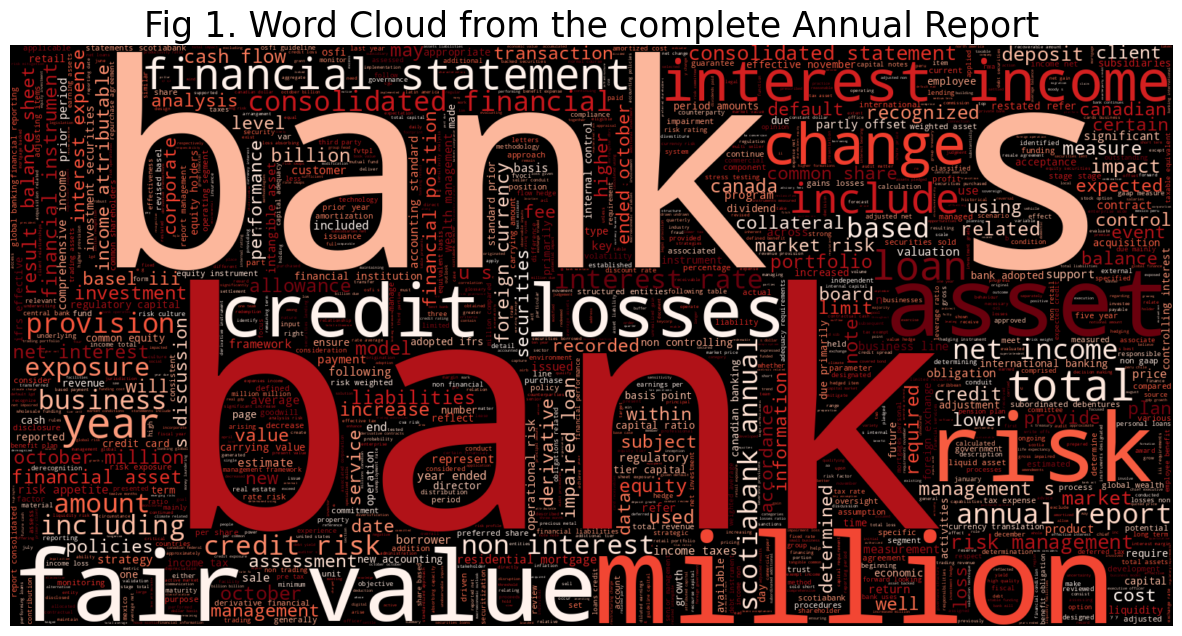

In [ ]:
#wordcloud to show the most common used words

# Join the list of strings into one large text
text = ' '.join(text_cleanned)

# Set up the figure
plt.figure(figsize=(15, 15))

# Generate the word cloud
wc = WordCloud(
    max_words=2000,
    width=1600,
    height=800,
    colormap='Reds',
    stopwords=STOPWORDS
).generate(text)

# Display the word cloud
plt.imshow(wc, interpolation='bilinear')
plt.title("Fig 1. Word Cloud from the complete Annual Report", fontsize=25)
plt.axis('off')
plt.show()



> The world cloud clearly states the most used words like:

* Bank
* Millions
* Credit losses
* Fair value
* Interest Income
* Asset
* Change Risk

>which highlight what the report will talk about.

>Also, we will find some hidden patterns that will speak louder than the highlighted words like:

* Global wealth
* Financial positon
* Report consolidated
* Wealth Management
* Derrivate Finnancial
* Liquid Assets

>These words provide a broader overview of the report's content. They highlight key themes such as the CEO's perspective on the company's performance over the past year, the results of Wealth Management in 2024, and the amount of liquid assets held. This information is essential for stakeholders, as it helps inform their future decisions—such as whether to buy, hold, or sell assets.

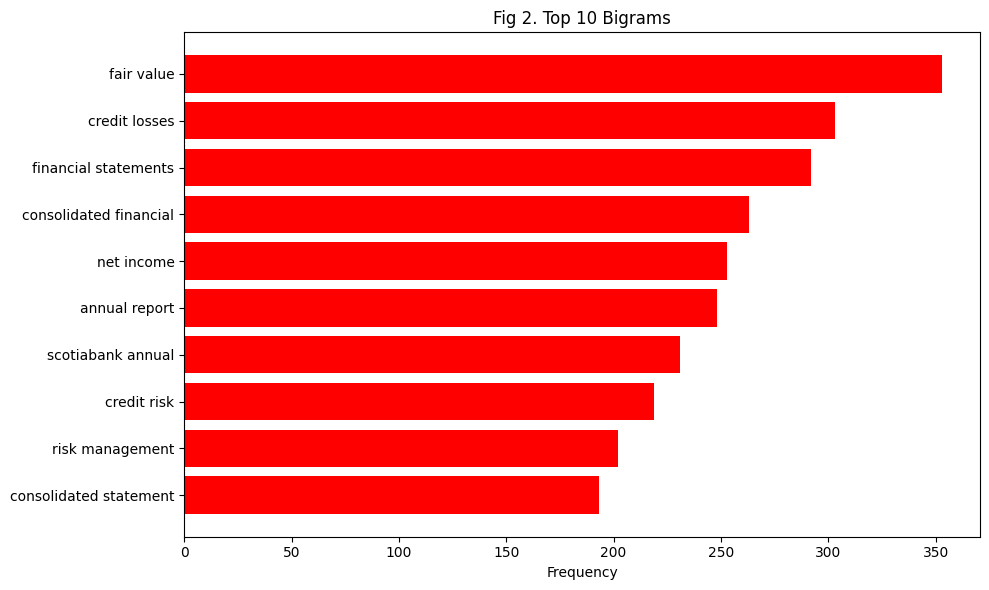

In [ ]:
#extract the bigrams and trigrams


# Combine all text into one string
text = ' '.join(text_cleanned)

# Set of English stopwords
stop_words = set(stopwords.words('english'))


# Tokenize text
tokens = nltk.word_tokenize(text.lower())

# Remove stopwords and non-alphabetic tokens
filtered_tokens = [word for word in tokens if word.isalpha() and word not in stop_words]


# Generate bigrams and trigrams
bigrams = list(ngrams(filtered_tokens, 2))
trigrams = list(ngrams(filtered_tokens, 3))

# Count frequency
bigram_freq = Counter(bigrams)
trigram_freq = Counter(trigrams)

# Get top 10 most common
top_bigrams = bigram_freq.most_common(10)
top_trigrams = trigram_freq.most_common(10)

# --- Plotting ---
def plot_ngrams(ngrams_freq, title):
    ngrams_list = [' '.join(gram) for gram, freq in ngrams_freq]
    freqs = [freq for gram, freq in ngrams_freq]

    plt.figure(figsize=(10, 6))
    plt.barh(ngrams_list[::-1], freqs[::-1], color='red')
    plt.title(title)
    plt.xlabel("Frequency")
    plt.tight_layout()
    plt.show()

plot_ngrams(top_bigrams, "Fig 2. Top 10 Bigrams")



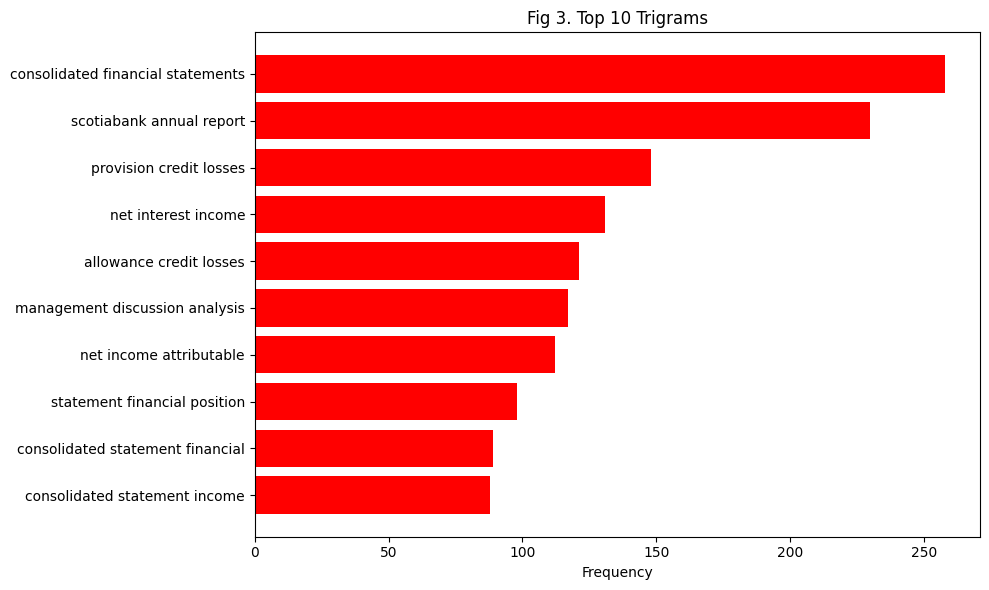

In [ ]:
plot_ngrams(top_trigrams, "Fig 3. Top 10 Trigrams")


> As shown in the bigrams and trigrams, the most frequently used word combinations in the report highlight key financial terminology. Recognizing these patterns is essential, especially when preparing to feed the data into language models such as Retrieval-Augmented Generation (RAG), which rely on contextual phrases—like bigrams and trigrams—to enhance text generation and understanding.

Examples such as:

* Fair value

* Financial statements

* Credit losses

are commonly used in financial reports, which explains their frequent appearance in the dataset.

* Additionally, terms like:

* Consolidated financial statements

* Net interest income

>are especially relevant. Since we’re dealing with structured financial tables, it's typical to find phrases like net interest income at the bottom of each table. This often reflects the outcome of key financial metrics and gives insight into the company’s revenue from interest-bearing assets—making it an essential element of financial analysis.



### Clean text and convert to chunks



> For better understanding of the document, it will be separated into chunks of information, which will give us information classified and organized according to the report, this way we can easily search for key topics like, global banking and markets.



> A list of sets will be created indicating the start and end of the chunks desire







In [ ]:
text_cleanned[0:4]

['annual report 2024',
 'scotiabank’s vision is to be our clients’ most trusted financial partner and deliver sustainable, profitable growth our strategy launched at our investor day in december 2023, our strategy focuses on four key pillars. grow and scale in priority markets we are deploying the majority of our incremental capital to our priority businesses in canada, the united states, and mexico to support our growth strategy, and to strengthen our connectivity across the north american corridor. earn primary client relationships leading with advice and following with solutions, we are working to create consistently high-quality experiences across all channels. make it easy to do business with us by simplifying and improving access to our products and services, we are committed to making it easier for our clients to bank with us. win as one team by investing in our people, culture, and communities, we are striving to be the employer of choice for all employees and creating an envir

In [ ]:
#tables we will removed from text since it will imported using tabula

#create a list of set with keyword that indicates the begining and end of a part of
#information of in the document.

intro = [
    ('Our Strategy', 'What’s inside'),
    ('CEO’s message to shareholders', 'President and CEO'),
    ('Chair’s message to shareholders', 'board of directors aaron w. regent'),
    ('board of directors aaron w. regent','since november 15, 2024'),
    ('ESG Highlights ENVIRONMENTAL', 'Climate-related finance consists of those products'),
    ('ScotiaRISE helps disadvantaged','MD&A Highlights Medium-Term'),
    ('MD&A Highlights Medium-Term', 'reference table for edtf'),
]


content = [
    ('Management’s Discussion & Analysis','SEC’s website at'),
    ('Management’s Discussion and Analysis FORWARD LOOKING STATEMENTS ','Additional information relating to the Bank'),
    ('Management’s Discussion and Analysis NON-GAAP MEASURES','T2 Reconciliation of reported and adjusted results and diluted earnings per share'),
    ('The Bank’s fiscal 2024 and 2023 results were adjusted for the following items.','T4 Reconciliation of reported and adjusted results by business line'),
    ('Constant Dollar International Banking business segment','T5 Reconciliation of International Banking’s reported and adjusted results and constant dollar results'),
    ('Earning and non-earning assets, core earning assets, core net interest income and net interest margin ','T6 Calculation of net interest margin Consolidated Bank '),
    ('Return on equity is a profitability measure','T7 Return on equity by operating segment'),
    ('Return on tangible common equity is a profitability measure ','T8 Return on tangible common equity '),
    ('Adjusted productivity ratio represents adjusted non-interest','OVERVIEW OF PERFORMANCE Financial Results: 2024 vs 2023'),
]


overview_preformance = [
    ('OVERVIEW OF PERFORMANCE Financial Results: 2024 vs 2023','Medium-term financial objectives The following table provides a summary'),
    ('Shareholder Returns In fiscal 2024, the total shareholder return on the Bank’s shares was', 'Management’s Discussion and Analysis T9 Shareholder returns'),
    ('Recent Developments On August 12, 2024', 'Strategy, Economic Summary and Outlook Strategy'),
    ('Strategy, Economic Summary and Outlook Strategy', 'Impact of Foreign Currency Translation The impact of foreign currency translation on net income is shown in the table below.'),
]

group_finnacial_preformance = [
    ('group financial performance net income net income was', 'Net Interest Income Net interest income was $19,252'),
    ('Net Interest Income Net interest income was $19,252', 'T11 Average balance sheet(1)and net interest income'),

    ('Non-interest income was $14,418 million','T13 Trading-related revenues (1)'),
    ('Provision for Credit Losses The provision for credit losses was','T14 Provision for credit losses by business line'),
    ('Non-interest expenses were $19,695 million, an increase','Provision for Income Taxes The effective tax rate was 20.5%'),
    ('Provision for Income Taxes The effective tax rate was 20.5%', 'Fourth Quarter Review T18 Fourth quarter financial results '),
    ('Net income Q4 2024 vs Q4 2023 Net income was $1,689 million compared to $1,354 million','Total revenue Q4 2024 vs Q4 2023 Revenues were $8,526 million compared to $8,272 million'),
    ('Total revenue Q4 2024 vs Q4 2023 Revenues were $8,526 million compared to $8,272 million', 'Provision for credit losses Q4 2024 vs Q4 2023 The provision for credit losses was $1,030 million, compared to $1,256 million'),
    ('Provision for credit losses Q4 2024 vs Q4 2023 The provision for credit losses was $1,030 million, compared to $1,256 million', 'Non-interest expenses Q4 2024 vs Q4 2023 Non-interest expenses were $5,296 million, a decrease of 4%'),

    ('Non-interest expenses Q4 2024 vs Q4 2023 Non-interest expenses were $5,296 million, a decrease of 4%', 'Provision for income taxes Q4 2024 vs Q4 2023 The effective tax rate was 23.2% compared to 9.1%'),
    ('Provision for income taxes Q4 2024 vs Q4 2023 The effective tax rate was 23.2% compared to 9.1%', 'Trending Analysis T19 Quarterly financial highlights'),
    ('Earnings over the period were driven by higher net interest income', 'Management’s Discussion and Analysis BUSINESS LINE OVERVIEW'),
]

business_line_overview = [
    ('Management’s Discussion and Analysis BUSINESS LINE OVERVIEW', 'T20 TEB Gross-up ($ millions)'),
    ('CANADIAN BANKING Canadian Banking reported net income attributable', 'INTERNATIONAL BANKING Net income attributable to equity holders was $2,714 million'),
    ('INTERNATIONAL BANKING Net income attributable to equity holders was $2,714 million', 'GLOBAL WEALTH MANAGEMENT Net income attributable to equity holders was $1,576 million, compared to'),
    ('GLOBAL WEALTH MANAGEMENT Net income attributable to equity holders was $1,576 million, compared to', 'GLOBAL BANKING AND MARKETS Global Banking and Markets reported net income attributable to equity'),
    ('GLOBAL BANKING AND MARKETS Global Banking and Markets reported net income attributable to equity','OTHER The Other segment reported a net loss attributable to equity holders of $2,494 million'),
    ('OTHER The Other segment reported a net loss attributable to equity holders of $2,494 million', 'KEY PERFORMANCE INDICATORS FOR ALL BUSINESS LINES Management uses a number of key metrics to monitor business line performance: '),
    ('Canadian Banking 2024 Achievements', 'Management’s Discussion and Analysis 2025 Priorities'),
    ('Management’s Discussion and Analysis 2025 Priorities','T22 Canadian Banking financial performance'),
    ('Financial Performance Net income Canadian Banking reported net income attributable to equity holders','Management’s Discussion and Analysis International Banking 2024 Achievements'),
    ('Management’s Discussion and Analysis International Banking 2024 Achievements','2025 Priorities Deepen client relationship'),
    ('2025 Priorities Deepen client relationship','T23 International Banking financial performance – Reported'),
    ('Management’s Discussion and Analysis Financial Performance Net income','T24 International Banking financial performance on reported and constant dollar basis'),
    ('Net income Net income attributable to equity holders was', 'Management’s Discussion and Analysis Global Wealth Management 2024 Achievements'),
    ('Management’s Discussion and Analysis Global Wealth Management 2024 Achievements', '2025 Priorities Earn primary client relationships'),
    ('2025 Priorities Earn primary client relationships', 'T25 Global Wealth Management financial performance'),
    ('Financial Performance Net income Net income attributable to equity holders was $1,576 million', 'Global Banking and Markets 2024 Achievements Earn primary client relationships'),
    ('Global Banking and Markets 2024 Achievements Earn primary client relationships', 'Management’s Discussion and Analysis 2025 Priorities Earn primary client relationships:'),
    ('Management’s Discussion and Analysis 2025 Priorities Earn primary client relationships:','T26 Global Banking and Markets financial performance'),
    ('Financial Performance Net income Global Banking and Markets reported net income', 'Management’s Discussion and Analysis Other'),
    ('Management’s Discussion and Analysis Other','Financial Performance T27 Other financial performance'),
    ('Net income The Other segment reported a net loss attributable to equity holders', 'GROUP FINANCIAL CONDITION T28 Condensed statement of financial position'),
]

group_finnacial_condition = [
    ('Statement of Financial Position Assets The Bank’s total assets were $1,412 billion as at October 31, 2024','Capital Management Overview Scotiabank is committed to maintaining'),
    ('Capital Management Overview Scotiabank is committed to maintaining', 'C22 Minimum Regulatory Capital Requirements (as at October 31, 2024)'),
    ('The Office of the Superintendent of Financial Institutions, Canada (OSFI)','C23 Continuity of Common Equity Tier 1 ratio (1)'),
    ('Regulatory capital components The Bank’s regulatory capital is divided into three components','T31 Selected capital management activity'),
    ('Normal Course Issuer Bid The Bank currently does not have an active normal course issuer bid ','T32 Shares and other instruments'),
    ('Credit ratings Credit ratings are one of the factors that impact the','T33 Flow statement for Basel III credit risk-weighted assets ($ millions)'),
    ('Credit risk-weighted assets – non-retail The Bank uses the Internal Ratings Based (IRB) approach under revised Basel III', 'T36 Portfolio-level comparison of estimated and actual non-retail percentages'),
    ('Credit risk-weighted assets – Canadian retail The AIRB approach is used to determine minimum regulatory','T37 Retail AIRB portfolio exposure by PD range'),
    ('All AIRB models and parameters are monitored on a quarterly basis and independently','T38 Estimated and actual loss parameters'),
    ('Credit risk-weighted assets – International retail International retail credit portfolios follow the Standardized approach and consist of the following components:','T39 Total market risk capital'),
    ('Market risk-weighted assets increased by $2.7 billion to $14.7 billion, as shown in the table above','Off-Balance Sheet Arrangements In the normal course of business, the Bank enters into contractual'),
    ('Off-Balance Sheet Arrangements In the normal course of business, the Bank enters into contractual', 'T41 Assets held by Bank-sponsored Canadian-based multi-seller conduits'),
    ('Structured finance entities The Bank has interests in structured finance entities used to assist corporate', 'Financial Instruments Given the nature of the Bank’s main business activities, financial instruments'),
    ('Financial Instruments Given the nature of the Bank’s main business activities, financial instruments','Selected Credit Instruments – Publicly Known Risk Items'),
    ('Selected Credit Instruments – Publicly Known Risk Items Mortgage-backed securities','T42 Mortgage-backed securities'),
]

risk_management = [

    ('Management’s Discussion and Analysis Risk Management Effective risk management is fundamental', 'Management’s Discussion and Analysis Principal Risks – Financial Credit Risk' ),
    ('Management’s Discussion and Analysis Principal Risks – Financial Credit Risk','better-than-expected productivity performance is resulting in an upward revision to our U.S. GDP over the forecast period' ),
    ('Allowance for credit losses The total allowance for credit losses as at October 31, 2024','T45 Impaired loans by business line' ),
    ('Impaired loans Gross impaired loans increased to $6,739 million','T46 Insured and uninsured residential mortgages and HELOCs, by geographic areas' ),
    ('Potential impact on residential mortgages and real estate home equity lines of credit in the event of', 'T49 Bank’s regional credit exposures distribution'),
    ('Management’s Discussion and Analysis Market Risk Market risk', 'T50 Structural interest sensitivity'),
    ('Internal risk transfer As per OSFI Capital Adequacy Requirements (CAR),', 'T51 Market risk measures'),
    ('Description of trading revenue components and graphical comparison of VaR to daily P&L','C29 Daily trading revenue vs. VaR'),
    ('Management’s Discussion and Analysis Credit valuation adjustment (CVA) risk', 'T52 Market risk linkage to Consolidated Statement of Financial Position of the Bank'),
    ('Derivative instruments and structured transactions Derivatives The Bank uses derivatives', 'Liquidity Risk Liquidity risk is the risk'),
    ('Liquidity Risk Liquidity risk is the risk','T53 Liquid asset pool'),
    ('The Bank’s liquidity pool is held across major currencies, mostly comprised of Canadian and U.S.', 'T55 Asset encumbrance'),
    ('As of October 31, 2024 total encumbered assets of the Bank were $421','T56 Bank’s average LCR'),
    ('HQLA is substantially comprised of Level 1 assets (as defined in the LAR Guideline)','T57 Bank’s NSFR'),
    ('Available stable funding (ASF) is primarily provided by the Bank’s large','T58 Wholesale funding'),
    ('Wholesale funding generally bears a higher risk of run-off','T59 Contractual maturities'),
    ('Principal Risks – Non-Financial Money Laundering, Terrorist Financing and Sanctions Risk', 'Controls and Accounting Policies Controls and Procedures'),
]

controls_acounting = [
    ('Controls and Accounting Policies Controls and Procedures','Critical Accounting Policies and Estimates The Bank’s accounting policies are integral'),
    ('Critical Accounting Policies and Estimates The Bank’s accounting policies are integral','Future Accounting Developments The Bank actively monitors developments and changes'),
    ('Future Accounting Developments The Bank actively monitors developments and changes','Regulatory Developments The Bank continues to monitor global regulatory developments'),
    ('Regulatory Developments The Bank continues to monitor global regulatory developments', 'Related Party Transactions Compensation of key management personnel Key management personnel are those persons'),
    ('Related Party Transactions Compensation of key management personnel Key management personnel are those persons','T60 Compensation of key management personnel of the Bank'),
    ('Scotiabank principal pension plan The Bank manages assets of $6.0 billion','Management’s Discussion and Analysis Supplementary Data'),

]

consolidated_finnacial_statement = [
    ('Consolidated Financial Statements MANAGEMENT’S RESPONSIBILITY FOR FINANCIAL INFORMATION','INDEPENDENT AUDITOR’S REPORT To the Shareholders and the Board of Directors of The Bank of Nova Scotia'),
    ('INDEPENDENT AUDITOR’S REPORT To the Shareholders and the Board of Directors of The Bank of Nova Scotia','REPORT OF INDEPENDENT REGISTERED PUBLIC ACCOUNTING FIRM To the Shareholders and the Board of Directors of The Bank of Nova Scotia'),
    ('REPORT OF INDEPENDENT REGISTERED PUBLIC ACCOUNTING FIRM To the Shareholders and the Board of Directors of The Bank of Nova Scotia','REPORT OF INDEPENDENT REGISTERED PUBLIC ACCOUNTING FIRM To the Shareholders and the Board of Directors of The Bank of Nova Scotia'),
    ('REPORT OF INDEPENDENT REGISTERED PUBLIC ACCOUNTING FIRM To the Shareholders and the Board of Directors of The Bank of Nova Scotia','Consolidated Statement of Financial Position As at October 31'),

]

notes_consolidated_finnacial_statement = [
    ('Consolidated Financial Statements MANAGEMENT’S RESPONSIBILITY FOR FINANCIAL INFORMATION','INDEPENDENT AUDITOR’S REPORT To the Shareholders and the Board of Directors of The Bank of Nova Scotia'),
    ('Reporting Entity The Bank of Nova Scotia','Basis of Preparation Statement of compliance'),
    ('Basis of Preparation Statement of compliance','Material Accounting Policies The material accounting policies used'),
    ('Material Accounting Policies The material accounting policies used','Transition to IFRS 17 On November 1, 2023'),
    ('Transition to IFRS 17 On November 1, 2023','Interest Rate Benchmark Reform The publication of the 1-month'),
    ('5 Interest Rate Benchmark Reform The publication of the 1-month, 2-month and 3-month Canadian Dollar Offered Rate (CDOR) tenors ceased as of June 28, 2024','Future Accounting Developments The Bank actively monitors'),
    ('6 Future Accounting Developments The Bank actively monitors','Cash and Deposits with Financial Institutions As at October 31'),
    ('Fair Value of Financial Instruments Determination of fair value','The fair values disclosed do not include non-financial assets, such as property and equipment, investments in associates, precious metals, goodwill and other intangible assets.'),
    ('Significant transfers Significant transfers can occur between','The table below sets out information about significant unobservable inputs used in measuring financial instruments categorized as Level 3 in the fair value hierarchy'),
    ('The Bank applies judgment in determining unobservable inputs used to calculate the fair value of Level 3 instruments.','Consolidated Financial Statements 9 Trading Assets'),
    ('Financial Instruments Designated at Fair Value Through Profit or Loss In accordance with its risk management strategy,','The following table presents the fair value of financial liabilities designated at fair value through profit or loss and their changes in fair value'),
    ('Consolidated Financial Statements 11 Derivative Financial Instruments','precious metals other than gold and other commodities.'),
    ('Credit risk As with other financial assets, derivative instruments are subject to credit risk','Commodity and other contracts includes energy, precious metals other than gold, and other commodities'),
    ('Hedging activities The Bank manages',' cash and deposit liabilities designated as hedging instruments.'),
    ('Offsetting Financial Assets and Financial Liabilities The Bank is eligible to present certain financial assets', 'as well as available cash and financial instrument collateral.'),
    ('Allowance for credit losses (i) Key inputs and assumptions', 'which represents a mediumterm view.'),
    ('Sensitivity Relative to the base case scenario', '(iv) Allowance for credit losses'),
    ('(g) Loans past due but not impaired', 'further during the deferral period.'),
    ('Derecognition of Financial Assets Securitization of residential mortgage loans', 'assets that do not qualify for derecognition and the associated liabilities:'),
    ('Securitization of credit card receivables The Bank securitizes a portion of its credit card', 'The following table provides the carrying amount of the transferred assets and the associated liabilities:'),
    ('Structured Entities (a) Consolidated structured entities','(b) Unconsolidated structured entities The following table provides information about'),
    ('The Bank’s maximum exposure to loss represents the notional amounts','17 Property and Equipment'),
    ('Impairment testing of Bank of Xi’an Co. Ltd','Summarized financial information of the Bank’s significant associates are as follows.'),
    ('Impairment testing of goodwill Goodwill acquired in business','customer relationships and core deposit intangibles.'),
    ('Impairment testing of intangible assets Indefinite life intangible assets are not','Consolidated Financial Statements 20 Other Assets'),
    ('Legal In the ordinary course of business','25 Common shares, preferred shares and other equity instruments (a) Common shares'),
    ('Dividend The dividends paid on common shares in fiscal 2024 and 2023','An unlimited number of preferred shares without nominal or par value. Issued and fully paid:'),
    ('Contractual NVCC provisions contained in the Bank’s Subordinated Additional','The Bank’s regulatory capital ratios were as follows'),
    ('Share-Based Payments (a) Stock option plans','the following weighted-average assumptions and resulting fair value per award:'),
    ('Employee share ownership plans Eligible employees can contribute up to a','Corporate income taxes recorded in the Bank’s consolidated financial statements for the years ended October 31 are as follows'),
    ('The tax related to temporary differences, unused tax losses and unused tax credits','Relative size of plan obligations and assets'),
    ('h) Assets','October 31, by asset category.'),
    ('Consolidated Financial Statements 30 Operating Segments', 'Scotiabank’s results, and average assets and liabilities, allocated by these operating segments, are as follows:'),
    ('(i) Standby letters of credit and letters of guarantee','Consolidated Statement of Financial Position.'),
    ('36 Financial Instruments – Risk Management The Bank’s principal business activities result in a balance','loan-to-value for real estate secured retail exposures.'),
    ('Consolidated Statement of Financial Position asset categories cross-referenced to credit risk exposures','of the Bank’s insurance subsidiaries.'),
    ('(ii) Credit quality of non-retail exposures','Cross referencing of internal ratings to external ratings'),
    ('Non-retail standardized portfolio','The data in the table below provides a distribution of the retail AIRB exposures within each PD range by asset class:'),
    ('Retail standardized portfolio The retail standardized portfolio','make no assumptions for management actions to mitigate the risk.'),
    ('(ii) Non-trading foreign currency risk','Bank’s VaR by risk factor:'),
    ('(d) Operational risk','The transaction increased the Bank’s CET1 ratio by approximately 16 basis points.'),

]



In [ ]:
#information used for report: list of dictionaries

intro_part =  process_files_in_folder(text_cleanned, intro, 'intro')
content_part =  process_files_in_folder(text_cleanned, content, 'content')
overview_preformance_part =  process_files_in_folder(text_cleanned, overview_preformance, 'overview_preformance')
group_finnacial_preformance_part =  process_files_in_folder(text_cleanned, group_finnacial_preformance, 'group_finnacial_preformance')
business_line_overview_part =  process_files_in_folder(text_cleanned, business_line_overview, 'business_line_overview')
group_finnacial_condition_part =  process_files_in_folder(text_cleanned, group_finnacial_condition, 'group_finnacial_condition')
risk_management_part =  process_files_in_folder(text_cleanned, risk_management, 'risk_management')
controls_acounting_part =  process_files_in_folder(text_cleanned, controls_acounting, 'controls_acounting')
consolidated_finnacial_statement_part =  process_files_in_folder(text_cleanned, consolidated_finnacial_statement, 'consolidated_finnacial_statement')
notes_consolidated_finnacial_statement_part =  process_files_in_folder(text_cleanned, notes_consolidated_finnacial_statement, 'notes_consolidated_finnacial_statement')


In [ ]:
content_part

[{'start_page': 19,
  'end_page': 19,
  'start_word': 'management’s discussion & analysis',
  'end_word': 'sec’s website at',
  'tag': 'content',
  'extracted_text': 'management’s discussion & analysis management’s discussion and analysis (md&a) is provided to enable readers to assess the bank’s financial condition and results of operations as at and for the year ended october 31, 2024. the md&a should be read in conjunction with the bank’s 2024 consolidated financial statements, including the notes. this md&a is dated december 3, 2024. additional information relating to the bank, including the bank’s 2024 annual report, are available on the bank’s website at as well, the bank’s 2024 annual report and annual information form are available on the sedar+ website at and on the edgar section of the'},
 {'start_page': 20,
  'end_page': 20,
  'start_word': 'management’s discussion and analysis forward looking statements ',
  'end_word': 'additional information relating to the bank',
  'tag':



> For ease of use, the chunks have been converted to a dataframe.




In [ ]:

# Convert each list of dictionaries to a DataFrame


intro_df = pd.DataFrame(intro_part)
content_df = pd.DataFrame(content_part)
overview_preformance_df = pd.DataFrame(overview_preformance_part)
group_finnacial_preformance_df = pd.DataFrame(group_finnacial_preformance_part)
business_line_overviews_df = pd.DataFrame(business_line_overview_part)
group_finnacial_condition_df = pd.DataFrame(group_finnacial_condition_part)
risk_management_df = pd.DataFrame(risk_management_part)
controls_acountin_df = pd.DataFrame(controls_acounting_part)
consolidated_finnacial_statement_df = pd.DataFrame(consolidated_finnacial_statement_part)
notes_consolidated_finnacial_statement_df = pd.DataFrame(notes_consolidated_finnacial_statement_part)


# Combine all DataFrames into one
finnacial_release_df = pd.concat([
    intro_df,
    content_df,
    overview_preformance_df,
    group_finnacial_preformance_df,
    business_line_overviews_df,
    group_finnacial_condition_df,
    risk_management_df,
    controls_acountin_df,
    consolidated_finnacial_statement_df,
    notes_consolidated_finnacial_statement_df
], ignore_index=True)


print('Shape',finnacial_release_df.shape)

Shape (128, 6)


In [ ]:
finnacial_release_df.head() #get first 5 rows

start_page  end_page                          start_word  \
0           2         3                        our strategy   
1           3        11       ceo’s message to shareholders   
2          13        14     chair’s message to shareholders   
3          14        14  board of directors aaron w. regent   
4          15        15        esg highlights environmental   

                                             end_word    tag  \
0                                       what’s inside  intro   
1                                   president and ceo  intro   
2                  board of directors aaron w. regent  intro   
3                             since november 15, 2024  intro   
4  climate-related finance consists of those products  intro   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [ ]:
finnacial_release_df.tail(10) # get last 10 rows


start_page  end_page  \
118         217       217   
119         218       218   
120         223       224   
121         225       226   
122         227       227   
123         228       228   
124         229       229   
125         229       230   
126         231       231   
127         231       232   

                                                                                                  start_word  \
118                                                                                                h) assets   
119                                                  consolidated financial statements 30 operating segments   
120                                                   (i) standby letters of credit and letters of guarantee   
121  36 financial instruments – risk management the bank’s principal business activities result in a balance   
122  consolidated statement of financial position asset categories cross-referenced to credit risk exposures   
123                                                              (ii) credit quality of non-retail exposures   
124                                                                        non-retail standardized portfolio   
125                                          retail standardized portfolio the retail standardized portfolio   
126                                                                   (ii) non-trading foreign currency risk   
127                                                                                     (d) operational risk   

                                                                                                                  end_word  \
118                                                                                         october 31, by asset category.   
119       scotiabank’s results, and average assets and liabilities, allocated by these operating segments, are as follows:   
120                                                                          consolidated statement of financial position.   
121                                                                loan-to-value for real estate secured retail exposures.   
122                                                                                  of the bank’s insurance subsidiaries.   
123                                                              cross referencing of internal ratings to external ratings   
124  the data in the table below provides a distribution of the retail airb exposures within each pd range by asset class:   
125                                                       make no assumptions for management actions to mitigate the risk.   
126                                                                                             bank’s var by risk factor:   
127                                      the transaction increased the bank’s cet1 ratio by approximately 16 basis points.   

                                        tag  \
118  notes_consolidated_finnacial_statement   
119  notes_consolidated_finnacial_statement   
120  notes_consolidated_finnacial_statement   
121  notes_consolidated_finnacial_statement   
122  notes_consolidated_finnacial_statement   
123  notes_consolidated_finnacial_statement   
124  notes_consolidated_finnacial_statement   
125  notes_consolidated_finnacial_statement   
126  notes_consolidated_finnacial_statement   
127  notes_consolidated_finnacial_statement   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [ ]:
#rows with no meaning
finnacial_release_df[finnacial_release_df['extracted_text'].apply(len) <100]

Empty DataFrame
Columns: [start_page, end_page, start_word, end_word, tag, extracted_text]
Index: []

In [ ]:
#drop columns if extracted text is less than 100 letters
finnacial_release_df.drop(finnacial_release_df[finnacial_release_df['extracted_text'].apply(len) <100].index, inplace=True)

In [ ]:

print('Shape',finnacial_release_df.shape)
finnacial_release_df.head()

Shape (128, 6)


start_page  end_page                          start_word  \
0           2         3                        our strategy   
1           3        11       ceo’s message to shareholders   
2          13        14     chair’s message to shareholders   
3          14        14  board of directors aaron w. regent   
4          15        15        esg highlights environmental   

                                             end_word    tag  \
0                                       what’s inside  intro   
1                                   president and ceo  intro   
2                  board of directors aaron w. regent  intro   
3                             since november 15, 2024  intro   
4  climate-related finance consists of those products  intro   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [ ]:
#save it for future use

finnacial_release_df.to_csv('finnacial_release_df.csv', index=False)



> After checking all the data extracted and noticing some rows had repeated information with no meaning at all, they were removed, and a df was obtained with only 128 rows and 6 features that will be used for training the models.


> Now it's time to load the tables in a format more readable like a table, for that tabula will be used, all the tables will be extracted, cleaned and given the proper format





### Clean tables and fix formating

In [ ]:
#check tables format

#first table
tables[0]

#frist table looks in a good shape, some negatives values needs to be
#modifed to look more like real values ex. negatives, nan

Aaron W. Regent                         Nora A. Aufreiter  \
0          • Chair of the Board                       • Human Capital and   
1       • Founder, Chairman and                    Compensation Committee   
2       Chief Executive Officer                       Chair and member of   
3         of Magris Performance                            Risk Committee   
4                Materials Inc.                      • Corporate director   
5   • Scotiabank director since               • Scotiabank director since   
6                 April 9, 2013                           August 25, 2014   
7                           NaN                       Guillermo E. Babatz   
8                           NaN                • Risk Committee Chair and   
9                           NaN                   member of Human Capital   
10                          NaN                and Compensation Committee   
11                          NaN  • Managing Partner of Atik Capital, S.C.   
12                          NaN               • Scotiabank director since   
13                          NaN                          January 28, 2014   

          Calin Rovinescu, C.M.  
0        • Corporate Governance  
1           Committee Chair and  
2       member of Human Capital  
3    and Compensation Committee  
4          • Corporate director  
5   • Scotiabank director since  
6              November 1, 2020  
7            Benita M. Warmbold  
8    • Audit and Conduct Review  
9           Committee Chair and  
10          member of Corporate  
11         Governance Committee  
12         • Corporate director  
13  • Scotiabank director since

In [ ]:
#let's check the last table
tables[len(tables)-1]

#this table needs more work done since this table has at least 2 tables merged together
#the library was not able to capture it correctly

For the year ended October 31, 2024\rAs at October 31, 2024AverageHighLow
0  $12.5$13.6$34.3$6.8\r7.38.413.65.9\r17.512.326.95.8\r5.45.110.13.0\r2.93.29.41.1\r2.82.64.61.3\r3.63.44.82.3\r(15.0)(13.1)n/an/a
1                                                                                                               $12.1$14.9$24.2$8.3



> To clean the tables and obtain the proper format, series of steps will be applied.

* add dollar sign to numeric values
* add dollar sign and negative to numeric values if the value is negative
* add header taking into consideration the number of rows that form part of the header
* remove innecesary columns or rows, like NaN or $ only
* join row base on the premises that if the prior column has in its 0 column some text and the other values are NaN, and the actual row is full of text and number then the text of the 0 column should be join as one.
* split the dataframe by rows when specific text is found (this is to give the proper format to each table, since some tables were load together
* remove extra dollar sign found on some numbers at the end



In [ ]:
print(f'Total Tables: {len(tables)}\n')


#check the amount of col and row ecach table has before cleaning
for index, table in enumerate(tables):
  print(f'\n Table number: {index}')
  print(f'Table dimmensions: {table.shape}' )



Total Tables: 6


 Table number: 0
Table dimmensions: (16, 11)

 Table number: 1
Table dimmensions: (49, 11)

 Table number: 2
Table dimmensions: (49, 10)

 Table number: 3
Table dimmensions: (49, 12)

 Table number: 4
Table dimmensions: (52, 12)

 Table number: 5
Table dimmensions: (54, 3)




> Since each table has been loaded in diffent structure, is needed to analyze the tables and apply the proper fix to each table, in order to match the report table



In [ ]:
#result table
result_table =[]

#iterate tables and apply different cleaning techniques depending on the table
for index, table in enumerate(tables):

  #get table clean
  df = table


  #changes to be apply to table 0 - Financial Highlights Reported Results
  if index == 0:

      # Apply the function to all cells in the DataFrame
      df = df.apply(lambda col: col.map(add_dollar_sign))
      #add $- to negative values
      df = df.apply(lambda col: col.map(add_dollar_negative_sign))

      # Apply the function to get new column names, number of col to take
      df.columns = add_headers(df,1)

      #remove row 0 and 1 the headers were added so is not necessary
      df.drop(index=[0], inplace=True)

      #drop all column that has no name
      df = df.loc[:, df.columns != '']

      # remove column names from (number) and .number
      df.columns = [remove_number_header(col) for col in df.columns]

      # Replace NaN values with empty strings
      df = df.fillna('')

      #add table 0
      result_table.append(df)


  elif index ==1:
      # Apply the function to all cells in the DataFrame
      df = df.apply(lambda col: col.map(add_dollar_sign))
      #add $- to negative values
      df = df.apply(lambda col: col.map(add_dollar_negative_sign))

      # Apply the function to get new column names
      df.columns = add_headers(df,1)
      #remove row 0 and 1 the headers were added so is not necessary
      df.drop(index=[0], inplace=True)

      # remove column names from (number) and .number
      df.columns = [remove_number_header(col) for col in df.columns]
      #remove second column , it does not contain any valuable info
      df.drop(df.columns[1], axis=1, inplace=True)
      # Apply the function to merge columns
      df = join_row_double_text(df)
      # Drop rows where all columns after the first one are NaN
      df.dropna(subset=df.columns[1:], how='all', inplace=True)

      #add table 0
      result_table.append(df)

  elif (index == 2) | (index == 3):

      # Apply the function to all cells in the DataFrame
      df = df.apply(lambda col: col.map(add_dollar_sign))

      #add $- to negative values
      df = df.apply(lambda col: col.map(add_dollar_negative_sign))

      # Apply the function to get new column names
      df.columns = add_headers(df,2)

      #remove row 0 and 1 the headers were added so is not necessary
      df.drop(index=[0, 1], inplace=True)

      # remove column names from (number) and .number
      df.columns = [remove_number_header(col) for col in df.columns]

      #remove second column , it does not contain any valuable info
      df.drop(df.columns[1], axis=1, inplace=True)

      # Apply the function to merge columns
      df = join_row_double_text(df)

      # Drop rows where all columns after the first one are NaN
      df.dropna(subset=df.columns[1:], how='all', inplace=True)

      split_text="For the three months"

      if index == 3 :
        split_text = "For the six months"

      check_columns = [0, 1, 2, 3, 4, 5, 6]  # List of column indices to check

      #add resutls to new table
      new_tables = split_dataframe_on_text(df, split_text, check_columns)

      for table in new_tables:
        check_columns = [0, 1, 2, 3, 4, 5, 6]
        found = any(split_text in str(table.iloc(0)[col]) for col in check_columns)
        if found:
          #remove first 3 rows
          table.drop(table.index[:4], inplace=True)

        result_table.append(table)
  elif index == 4:
      #find row in first column  that start with Reported Results and split the dataset
      # Find indices where the column starts with 'Reported Results'
      # Find the index of rows where the column starts with 'Reported Results'
      new_tables = split_dataframe_on_text_column(table, 'Reported Results', 0)

      for index, tab in enumerate(new_tables):

        if index == 0:

          # Apply the function to get new column names
          tab.columns = add_headers(tab,2)

          #remove row 0 and 1 the headers were added so is not necessary
          tab.drop(index=[0, 1], inplace=True)

          # remove column names from (number) and .number
          tab.columns = [remove_number_header(col) for col in tab.columns]

          # Drop rows where all columns after the first one are NaN
          index_remove = tab[tab['($ millions)'] == 'Adjusted net income attributable to common shareholders'].index

          #remove from index_remove row until end
          tab.drop(index= tab.index[index_remove[0] -1:], inplace=True)

          # Apply the function to merge columns
          tab = join_row_double_text(tab)

          # Drop rows where all columns after the first one are NaN
          tab.dropna(subset=tab.columns[1:], how='all', inplace=True)

          # Drop columns where the column name is an empty string
          tab = tab.loc[:, tab.columns != '']

          #remove dollar sign from the end
          tab = remove_dollar_sign(tab)

          # Apply the function to all cells in the DataFrame
          tab = tab.apply(lambda col: col.map(add_dollar_sign))

          #add $- to negative values
          tab = tab.apply(lambda col: col.map(add_dollar_negative_sign))

          #add table 0
          result_table.append(tab)
        else:
          #create new df
          newDF = pd.DataFrame()

          # Define a regular expression pattern to split based on the presence of a number
          pattern = r'(\D*)\s?(\d[,\d]*)'

          # Extract the text part and the numeric part into separate columns
          newDF[['Reported Results ($ millions)', 'January 31, 2024 Reported']] = tab['Unnamed: 0'].str.extract(pattern, expand=True)

          #drop null values
          newDF.dropna(inplace=True)

          #reset index
          newDF =newDF.reset_index(drop=True)

          #drop index 0
          newDF.drop(index=0, inplace=True)

          #table reset indx
          tab =tab.reset_index(drop=True)

          #drop first 4 rows after secodn column
          tab =tab.iloc[4:,2:]

          # Join all columns into a single column
          tab['combined']= tab.apply(lambda row: ' '.join(row.dropna().astype(str)), axis=1)

          #drop empty rows
          tab.drop(tab[ tab['combined'] == ''].index, inplace=True)

          #remove dollar sign from column combined
          tab['combined'] = tab['combined'].str.replace('$', '')

          #remove double space
          tab['combined'] = tab['combined'].str.replace('  ', ' ')

          # Split the 'Values' column into multiple columns
          df_split = tab['combined'].str.split(' ', expand=True)

          # Rename the columns
          df_split.columns = [f'Value_{i+1}' for i in range(df_split.shape[1])]
          df_split = df_split.reset_index(drop=True)
          newDF = newDF.reset_index(drop=True)

          #join newDF and df_split
          newDF = pd.concat([newDF, df_split], axis=1)

          #add dollar sign
          newDF = newDF.apply(lambda col: col.map(add_dollar_sign))

          #add negatives
          newDF = newDF.apply(lambda col: col.map(add_dollar_negative_sign))

          #rename cols
          newDF.columns = ['Reported Results ($ millions)',
                          'For the three months ended January 31, 2024 Reported',
                          'For the three months ended January 31, 2024 Foreign exchange',
                          'For the three months ended January 31, 2024 Constant dollar',
                          'For the three months ended April 30, 2023 Reported',
                          'For the three months ended April 30, 2023 Foreign exchange',
                          'For the three months ended April 30, 2023 Constant dollar',
                          'For the six months ended April 30, 2023 Reported',
                          'For the six months ended April 30, 2023 Foreign exchange',
                          'For the six months ended April 30, 2023 Constant dollar',
                            ]

          result_table.append(newDF)
  elif index == 5:
      #find row in first column  that start with Reported Results and split the dataset
      # Find indices where the column starts with 'Reported Results'
      # Find the index of rows where the column starts with 'Reported Results'
      new_tables = split_dataframe_on_text_column(df, 'Return on equity by operating segment', 0)

      for index, tab in enumerate(new_tables):

        if index == 0:
          #remove col name
          tab.columns = [f'Value_{i+1}' for i in range(tab.shape[1])]

          # Drop rows where all columns after the first one are NaN
          index_remove = tab[tab['Value_1'].str.contains('Net income attributable to equity holders of the Bank', na = False)].index

          #remove from index_remove row until end
          tab.drop(index= tab.index[index_remove[0] +1 :], inplace=True)
          #drop first 4 rows
          tab =tab.iloc[3:]

          # Join all columns into a single column
          tab['combined']= tab.apply(lambda row: ' '.join(row.dropna().astype(str)), axis=1)

          #remove dollar sign from column combined
          tab['combined'] = tab['combined'].str.replace('$', '')

          #remove double space
          tab['combined'] = tab['combined'].str.replace('  ', ' ')


          #create new df
          newDF = pd.DataFrame()

          # Define a regular expression pattern to split based on the presence of a number
          pattern = r'(\D*)\s?(\d[,\d]*)'

          # Extract the text part and the numeric part into separate columns
          newDF[['Adjusted Results ($ millions)','values']] = tab['combined'].str.extract(pattern, expand=True)
          #remove text from numbers
          newDF['Cleaned'] = tab['combined'].apply(lambda x: re.sub(r'[a-zA-Z]', '', x))

          newDF['Cleaned'] = newDF['Cleaned'].str.replace('-', '')
          newDF['Cleaned'] = newDF['Cleaned'].str.replace('()', '')

          # Split the column based on spaces
          # Convert each split item to a string and remove unwanted characters
          df_split =  newDF['Cleaned'].str.split(r'\s+', expand=True)

          # Drop unnecessary rows if there are empty columns or adjust if needed
          # Rename columns for clarity
          df_split.columns = [f'Value_{i+1}' for i in range(df_split.shape[1])]


          #get only first col
          newDF = newDF[['Adjusted Results ($ millions)']]

          #remove col value! and empty rows
          df_split.drop(df_split.columns[0], axis=1, inplace=True)
          # df_split.dropna(inplace=True)

          df_split = df_split.reset_index(drop=True)
          newDF = newDF.reset_index(drop=True)

          #join newDF and df_split
          newDF = pd.concat([newDF, df_split], axis=1)

          #add dollar sign
          newDF = newDF.apply(lambda col: col.map(add_dollar_sign))

          #add negatives
          newDF = newDF.apply(lambda col: col.map(add_dollar_negative_sign))

          #rename cols
          newDF.columns = ['Adjusted Results ($ millions)',
                          'For the three months ended January 31, 2024 Adjusted',
                          'For the three months ended January 31, 2024 Foreign exchange',
                          'For the three months ended January 31, 2024 Constant dollar adjusted',
                          'For the three months ended April 30, 2023 Adjusted',
                          'For the three months ended April 30, 2023 Foreign exchange',
                          'For the three months ended April 30, 2023 Constant dollar adjusted',
                          'For the six months ended April 30, 2023 Adjusted',
                          'For the six months ended April 30, 2023 Foreign exchange',
                          'For the six months ended April 30, 2023 Constant dollar adjusted',
                            ]

          result_table.append(newDF)

        else:
          tab.reset_index(drop=True, inplace=True)

          #remove col name
          tab.columns = [f'Value_{i+1}' for i in range(tab.shape[1])]

          #drop first 4 rows
          tab =tab.iloc[6:]

          # Join all columns into a single column
          tab['combined']= tab.apply(lambda row: ' '.join(row.dropna().astype(str)), axis=1)

          #remove dollar sign from column combined
          tab['combined'] = tab['combined'].str.replace('$', '')

          #remove double space
          tab['combined'] = tab['combined'].str.replace('  ', ' ')

          #create new df
          newDF = pd.DataFrame()

          #join row title
          strNew = ''
          newList = []
          for a in tab['combined']:
            if len(a) < 30:
              #add to new df
              a = a.replace('(','')
              a = a.replace(')','')
              a = re.sub(r'\d','', a)
              strNew += a + ' '
            else:
              #add to new df
              strNew += a + ' '
              newList.append(strNew)
              strNew = ''


          newDF = pd.DataFrame( newList, columns=['combined'])

          # Define a regular expression pattern to split based on the presence of a number
          pattern = r'(\D*)\s?(\d[,\d]*)'

          # # Extract the text part and the numeric part into separate columns
          newDF[['($ millions)','values']] = newDF['combined'].str.extract(pattern, expand=True)

          #remove text from numbers
          newDF['Cleaned'] = newDF['combined'].apply(lambda x: re.sub(r'[a-zA-Z]', '', x))

          newDF['Cleaned'] = newDF['Cleaned'].str.replace('-', '')
          newDF['Cleaned'] = newDF['Cleaned'].str.replace('()', '')
          newDF['Cleaned'] = newDF['Cleaned'].str.replace('(2)(3)', '')
          newDF['Cleaned'] = newDF['Cleaned'].str.replace('(4)', 'nm(4)')

          # Split the column based on spaces
          # Convert each split item to a string and remove unwanted characters
          df_split =  newDF['Cleaned'].str.split(r'\s+', expand=True)

          # Drop unnecessary rows if there are empty columns or adjust if needed
          # Rename columns for clarity
          df_split.columns = [f'Value_{i+1}' for i in range(df_split.shape[1])]

          #get only first col
          newDF = newDF[['($ millions)']]

          #remove col value! and empty rows
          df_split.drop(df_split.columns[[0,13]], axis=1, inplace=True)
          # df_split.dropna(inplace=True)

          df_split = df_split.reset_index(drop=True)
          newDF = newDF.reset_index(drop=True)

          #join newDF and df_split
          newDF = pd.concat([newDF, df_split], axis=1)

          #add dollar sign
          newDF = newDF.apply(lambda col: col.map( add_dollar_sign))

          #add negatives
          newDF = newDF.apply(lambda col: col.map(add_dollar_negative_sign))

          # #rename cols
          newDF.columns = ['($ millions)',
                          'For the three months ended April 30, 2024 Canadian Banking',
                          'For the three months ended April 30, 2024 International Banking',
                          'For the three months ended April 30, 2024 Global Wealth Management',
                          'For the three months ended April 30, 2024 Global Banking and Markets',
                          'For the three months ended April 30, 2024 Other',
                          'For the three months ended April 30, 2024 Total',
                          'For the three months ended April 30, 2023 Canadian Banking',
                          'For the three months ended April 30, 2023 International Banking',
                          'For the three months ended April 30, 2023 Global Wealth Management',
                          'For the three months ended April 30, 2023 Global Banking and Markets',
                          'For the three months ended April 30, 2023 Other',
                          'For the three months ended April 30, 2023 Total',
                          ]

          result_table.append(newDF)





<ipython-input-21-aaf8b0b051f9>:87: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if pd.isna(row[0]):
<ipython-input-21-aaf8b0b051f9>:92: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  found = text in str(row[0])
<ipython-input-21-aaf8b0b051f9>:89: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  found = any(text in str(row[col]) for col in check_columns)
<ipython-input-40-01ecc53ebf5c>:102: SettingWithCopyWarning: 
A value is trying to

In [ ]:
print(f'Total Tables: {len(result_table)}\n')


#iterate tables and apply different cleaning techniques depending on the table
for index, table in enumerate(result_table):
  print(f'\n Table number: {index +1}')
  print(f'Table dimmensions: {table.shape}' )



Total Tables: 10


 Table number: 1
Table dimmensions: (15, 6)

 Table number: 2
Table dimmensions: (38, 6)

 Table number: 3
Table dimmensions: (14, 7)

 Table number: 4
Table dimmensions: (14, 7)

 Table number: 5
Table dimmensions: (14, 7)

 Table number: 6
Table dimmensions: (14, 7)

 Table number: 7
Table dimmensions: (16, 7)

 Table number: 8
Table dimmensions: (11, 10)

 Table number: 9
Table dimmensions: (10, 10)

 Table number: 10
Table dimmensions: (5, 13)


In [ ]:
#save all tables for future use
for index, table in enumerate(result_table):
  table.to_csv(f'table_{index}.csv', index=False)

### 6. Exploratory Data Analysis (After Cleaning and transform into dataset)

In [ ]:
finnacial_release_df.head()

start_page  end_page                          start_word  \
0           2         3                        our strategy   
1           3        11       ceo’s message to shareholders   
2          13        14     chair’s message to shareholders   
3          14        14  board of directors aaron w. regent   
4          15        15        esg highlights environmental   

                                             end_word    tag  \
0                                       what’s inside  intro   
1                                   president and ceo  intro   
2                  board of directors aaron w. regent  intro   
3                             since november 15, 2024  intro   
4  climate-related finance consists of those products  intro   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

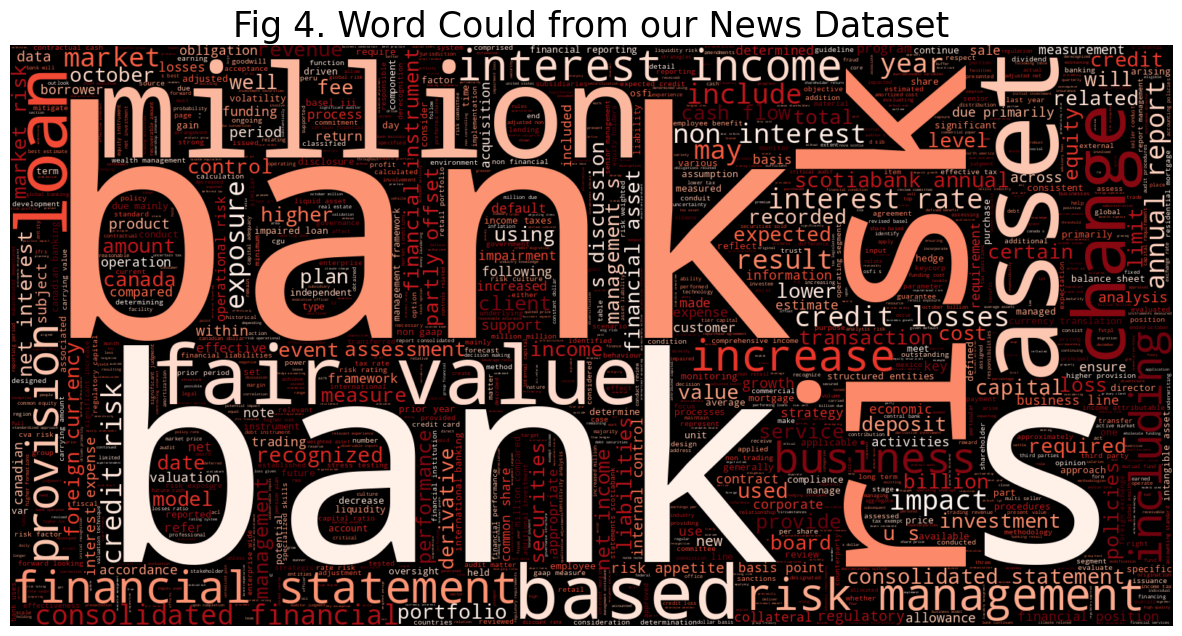

In [ ]:
#Word cloud to grasp a wider idea about what the dataset is about


#define figure size
plt.figure(figsize=(15, 15))
#define a word cloud with max 2000 words and without stopwords (from same wordcloud)
wc = WordCloud(max_words=2000, width=1600, height=800, colormap='Reds', stopwords=STOPWORDS).generate(' '.join(finnacial_release_df['extracted_text']))
#show image
plt.imshow(wc, interpolation='bilinear')
#add title
plt.title("Fig 4. Word Could from our News Dataset", fontsize=25)
#hide axis
plt.axis('off')

plt.show()

> The world cloud clearly states the most used words like:

* Bank
* Million
* Risk
* Risk Management
* Financial Statement

>which highlight what the report will talk about.

>Also, we will find some hidden patterns that will speak louder than the highlighted words like:

* Financial Instrument
* Consolidated Financial
* Market Risk
* Foreign currency
* Interest Rate

>These words provide a broader overview of the report's content. They highlight key themes such as the CEO's perspective on the company's performance over the past year, the results of Wealth Management in 2024, and the amount of liquid assets held. This information is essential for stakeholders, as it helps inform their future decisions—such as whether to buy, hold, or sell assets.

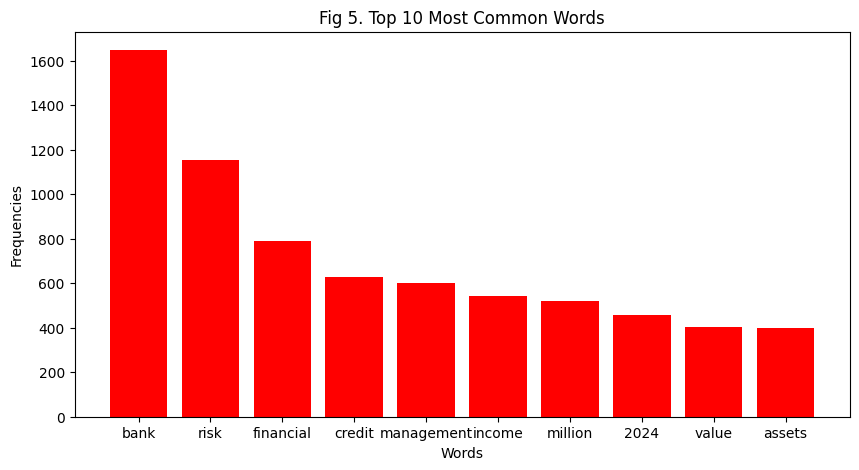

In [ ]:
#get the top 10 most common words
#just for this the stop words will be eliminated
stop_words = set(stopwords.words('english'))

# Tokenize all text data and remove stop words
all_words = []
for text in finnacial_release_df['extracted_text']:
    tokens = word_tokenize(text.lower())
    filtered_tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
    all_words.extend(filtered_tokens)


# Get the frequency distribution of the words
freq_dist = FreqDist(all_words)

# Get the top 10 most common words
top_10_words = freq_dist.most_common(10)

# Unzip the words and their frequencies for plotting
words, frequencies = zip(*top_10_words)

# Plot the top 10 words
plt.figure(figsize=(10, 5))
plt.bar(words, frequencies, color='red')
plt.xlabel('Words')
plt.ylabel('Frequencies')
plt.title('Fig 5. Top 10 Most Common Words')
plt.show()

>This bar graph illustrates the most frequently repeated words in the document. Complementing the word cloud, it clearly identifies the most commonly used terms, providing a detailed view of their frequency.

In [ ]:
# tokenize text and remove stop words
def tokenize_and_clean(text):
    tokens = word_tokenize(text.lower())
    filtered_tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
    return filtered_tokens

# Collect all words from the text column
all_words = []
for text in finnacial_release_df['extracted_text']:
    filtered_tokens = tokenize_and_clean(text)
    all_words.extend(filtered_tokens)

# get top n-grams
def get_top_ngrams(words, n, top_n=10):
    n_grams = ngrams(words, n)
    n_grams_freq = Counter(n_grams)
    return n_grams_freq.most_common(top_n)

Top Bigrams:
fair value: 242
october 31: 208
risk management: 194
financial statements: 194
consolidated financial: 181
credit losses: 173
credit risk: 168
annual report: 156
2024 scotiabank: 141
scotiabank annual: 141


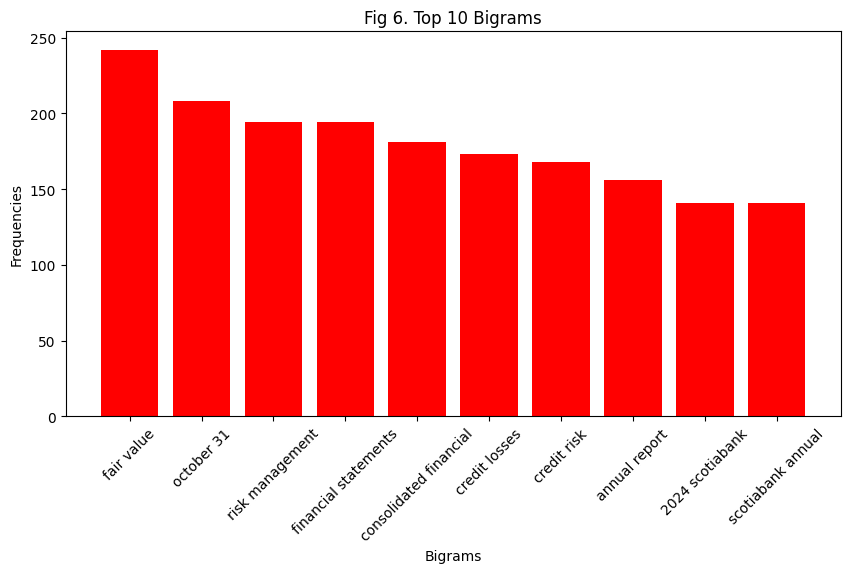

In [ ]:

# Get top bigrams
top_bigrams = get_top_ngrams(all_words, 2)

# Display top bigrams
print("Top Bigrams:")
for gram, freq in top_bigrams:
    print(f"{' '.join(gram)}: {freq}")


# Plot the top bigrams
bigrams, bigram_freqs = zip(*top_bigrams)
bigram_labels = [' '.join(gram) for gram in bigrams]

plt.figure(figsize=(10, 5))
plt.bar(bigram_labels, bigram_freqs, color='red')
plt.xlabel('Bigrams')
plt.ylabel('Frequencies')
plt.title('Fig 6. Top 10 Bigrams')
plt.xticks(rotation=45)
plt.show()


Top Trigrams:
consolidated financial statements: 175
2024 scotiabank annual: 141
scotiabank annual report: 140
october 31 2024: 119
provision credit losses: 98
management discussion analysis: 87
net interest income: 80
consolidated statement income: 75
statement financial position: 59
october 31 2023: 58


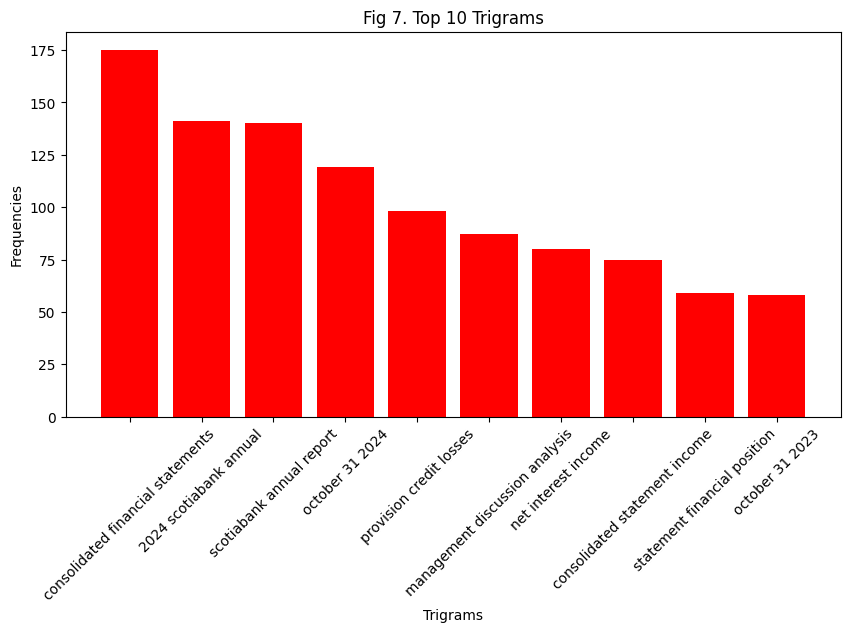

In [ ]:
#get top  trigrams
top_trigrams = get_top_ngrams(all_words, 3)


# Display top trigrams
print("\nTop Trigrams:")
for gram, freq in top_trigrams:
    print(f"{' '.join(gram)}: {freq}")



# Plot the top trigrams
trigrams, trigram_freqs = zip(*top_trigrams)
trigram_labels = [' '.join(gram) for gram in trigrams]

plt.figure(figsize=(10, 5))
plt.bar(trigram_labels, trigram_freqs, color='red')
plt.xlabel('Trigrams')
plt.ylabel('Frequencies')
plt.title('Fig 7. Top 10 Trigrams')
plt.xticks(rotation=45)
plt.show()

>As shown in the bigrams and trigrams, the most frequently used word combinations in the report highlight key financial terminology that is central to understanding the nature and focus of the document. Identifying these recurring patterns is not only useful for textual analysis but is also crucial when preparing the data for advanced language models such as Retrieval-Augmented Generation (RAG). These models leverage contextual phrases—like bigrams and trigrams—to better comprehend and generate domain-specific text, enabling more accurate and relevant outputs in downstream tasks such as summarization, question answering, and document retrieval.
Examples such as:

* Fair value
* Financial statements
* Risk management
* Consolidated financial

are commonly used in financial reports, which explains their frequent appearance in the dataset.

Additionally, terms like:

* Consolidated financial statements
* Management discussion analysis
* Consolidated statement income
* Statement financial position


>Are particularly relevant in the context of corporate financial reporting. These phrases represent standard components of annual and quarterly reports, and they serve as structured sections through which a company communicates its financial health, performance, and strategic outlook to stakeholders.

>For example, the consolidated financial statements provide a comprehensive view of the financial position of the entire corporate group, combining the financials of the parent company and its subsidiaries. The management discussion and analysis (MD&A) section offers qualitative insights, where executives interpret the numbers, explain performance trends, and outline future expectations—adding a narrative layer to the quantitative data.

### 7. Modeling

I. Load library and dataset

Note. since the notebook is large,all dataset has been save for future use, in case someone wish to start or continue from modeling

In [127]:
#since we are not going to do the scrapping everytime we need to run the book
#we will load the dataset

import pandas as pd
import numpy as np

#text manipulation
import nltk
from nltk.tokenize import sent_tokenize
from fuzzywuzzy import fuzz
from prettytable import PrettyTable

#transformers
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import pipeline
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from transformers import BertTokenizer, BertForQuestionAnswering,BertModel, Trainer, TrainingArguments
from sentence_transformers import SentenceTransformer, util
from torch.nn.functional import cosine_similarity

#language
from langdetect import detect
from transformers import MarianMTModel, MarianTokenizer


from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer

import json
import torch
from tqdm import tqdm
from datasets import load_dataset
from transformers import AutoTokenizer
from transformers import AutoModelForQuestionAnswering
from transformers import TrainingArguments, Trainer



from langchain_community.llms import LlamaCpp
from langchain.chains import RetrievalQA
from langchain.vectorstores import FAISS
from langchain.embeddings import HuggingFaceEmbeddings
from llama_cpp import Llama
from langchain.chains import ConversationalRetrievalChain
from langchain.chains import LLMChain
from langchain.memory import ConversationBufferMemory


import os

from langchain.prompts import PromptTemplate

import evaluate
from langchain.vectorstores import FAISS
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.text_splitter import CharacterTextSplitter



In [128]:
#if you aleady has all the values loaded, from the begining of the notebook, then
#there is no need to run this line
#load all data already preproseced

#load file from google drive
from google.colab import drive
drive.mount('/content/drive')



# load report file from gogle drive
csv_path = "/content/drive/My Drive/finnacial_release_df.csv"


financial_df = pd.read_csv(csv_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [129]:
financial_df.head()

start_page  end_page                          start_word  \
0           2         3                        our strategy   
1           3        11       ceo’s message to shareholders   
2          13        14     chair’s message to shareholders   
3          14        14  board of directors aaron w. regent   
4          15        15        esg highlights environmental   

                                             end_word    tag  \
0                                       what’s inside  intro   
1                                   president and ceo  intro   
2                  board of directors aaron w. regent  intro   
3                             since november 15, 2024  intro   
4  climate-related finance consists of those products  intro   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [ ]:
#if you aleady has all the values loaded, from the begining of the notebook, then
#there is no need to run this line
#load all data already preproseced

financial_df = pd.read_csv('finnacial_release_df.csv')
table0 = pd.read_csv('table_0.csv')
table1 = pd.read_csv('table_1.csv')
table2 = pd.read_csv('table_2.csv')
table3 = pd.read_csv('table_3.csv')
table4 = pd.read_csv('table_4.csv')
table5 = pd.read_csv('table_5.csv')
table6 = pd.read_csv('table_6.csv')
table7 = pd.read_csv('table_7.csv')
table8 = pd.read_csv('table_8.csv')
table9 = pd.read_csv('table_9.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'finnacial_release_df.csv'

In [ ]:
#join tables
tablesList = [table0, table1, table2, table3, table4, table5, table6, table7, table8, table9]


NameError: name 'table0' is not defined

In [130]:
print(torch.cuda.is_available())

False


In [131]:
#ensuring that our model will run with cuda, since we will use images, we need GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cpu


##### II. Define metrics functions

* Bleu: is a proudct of the Brevity penalty that penalize short text that do not contain relavant info from the reference provided.
* Perplexity :  perplexity assesses the "confidence"  of a language model in predicting the next word in a sequence of words.
* Meteor : evaluates accurracy and fluency, takes the order of which words appear
* Rouge: calculate the number of ngrams matching

In [132]:

# Load metrics
bleu = evaluate.load("bleu")
rouge = evaluate.load("rouge")
meteor = evaluate.load("meteor")
bertscore = evaluate.load("bertscore")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [133]:

# Create a RougeScorer object
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)


#calculate bleu
def calculate_bleu(reference, candidate):
    reference = [reference.split()]
    candidate = candidate.split()
    return sentence_bleu(reference, candidate)

#calculate meteor
def calculate_meteor(reference, candidate):
    return meteor_score([reference], candidate)

#calculate rouge
def calculate_rouge(reference, candidate):
    scores = scorer.score(reference, candidate)
    return scores



def calculate_perplexity(text, model, tokenizer):
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    model.to(device)

    # Get the model's output logits
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=input_ids)
        logits = outputs.logits
        loss = outputs.loss.item()  # Compute the loss (negative log likelihood)

    # Calculate perplexity
    perplexity = math.exp(loss)

    return perplexity

In [135]:
#given the required data, evaluate all metrics required to determine which model is better
def evaluate_all_metrics(generated_answer, reference_answer):
    bleu_scores = []
    meteor_scores = []
    rouge_scores = []
    perplexity = []

     # Calculate BLEU
    bleu_score = calculate_bleu(reference_answer, generated_answer)
    bleu_scores.append(bleu_score)

    # Calculate METEOR Unigrams can be matched based on their surface forms, stemmed forms, and meanings
    meteor_score_value = calculate_meteor(nltk.word_tokenize(reference_answer) , nltk.word_tokenize(generated_answer))
    meteor_scores.append(meteor_score_value)

    # Calculate ROUGE
    rouge_score = calculate_rouge(reference_answer, generated_answer)
    rouge_scores.append(rouge_score)

    return bleu_scores, meteor_scores, rouge_scores





> Fuzzy string matching uses Levenshtein Distance to calculate the differences between sequences.



In [136]:
def get_relevant_data(question, table_df):
    try:
        # Normalize the query
        question = question.lower().strip()

        # Use fuzzy matching for more flexible querying
        def match_row(row):
            row_str = row.astype(str).str.lower().str.strip()
            for cell in row_str:
                if fuzz.partial_ratio(question, cell) > 80:  # Threshold can be adjusted
                    return True
            return False

        matched_rows = table_df.apply(match_row, axis=1)
        results = table_df[matched_rows]

        if not results.empty:
            if len(results) > 10:
                results = results.head(10)
            return results
        else:
            return pd.DataFrame()  # Return an empty DataFrame if no results are found
    except Exception as e:
        print(f"Error retrieving data: {e}")
        return pd.DataFrame()  # Retur

In [137]:
def dataframe_to_prettytable(df):
    """Convert DataFrame to PrettyTable."""
    if df.empty:
        return None

    table = PrettyTable()
    table.field_names = df.columns.tolist()

    for index, row in df.iterrows():
        table.add_row(row.tolist())

    return table

In [138]:
def check_allTables_relevan_data(question, tablesList):

    relevant_data=''
   # Fetch relevant data from each DataFrame
    for i, table in enumerate(tablesList, start=1):
        data = get_relevant_data(question, table)
        table_str = dataframe_to_prettytable(data)
        if table_str:
            relevant_data += f"Relevant data from Table {i}:\n{table_str}\n\n"
    return relevant_data


#### III. Bert (bert-large-uncased-whole-word-masking-finetuned-squad)

Bert for question and answering: Is a model that given a question and context, identify the proper response.

>Since, the PDF has been extracted and there is no question file or guide of the questions that might pop up, embedings will be used.

> When a user types a question, base on the embedings already created, and using the cosine similarity, the most proper sentences will be collected, this list of response will then be given to the Bert model for identify the proper answer.



In [ ]:
#create a copy to implement with bert
df_bert = financial_df.copy()

In [ ]:
# Load sentence transformer for semantic similarity
embedder = SentenceTransformer('all-MiniLM-L6-v2')

#sentence-transformers model maps sentences & paragraphs to a 384 dimensional
#dense vector space and can be used for tasks like clustering or semantic search.



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# Embed all the extracted_text chunks
df_bert['embedding'] = df_bert['extracted_text'].apply(lambda x: embedder.encode(x, convert_to_tensor=True))

In [ ]:
df_bert.head(1) #show embeding

start_page  end_page    start_word       end_word    tag  \
0           2         3  our strategy  what’s inside  intro   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  extracted_text  \
0  our strategy launched at our investor day in december 2023, our strategy focuses on four key pillars. grow and scale in priority markets we are deploying the majority of our incremental capital to our priority businesses in canada, the united states, and mexico to support our growth strategy, and to strengthen our connectivity across the north american corridor. earn primary client relationships leading with advice and following with solutions, we are working to create consistently high-quality experiences across all channels. make it easy to do business with us by simplifying and improving access to our products and services, we are committed to making it easier for our clients to bank with us. win as one team by investing in our people, culture, and communities, we are striving to be the employer of choice for all employees and creating an environment where everyone can thrive. reported net income $7. 9 bn adjusted net income2 $8.6 bn reported return on equity1 10.2% adjusted return on equity2 11.3% total assets $1.4 t common equity tier 1 (cet1) ratio3 13.1% 1 refer to glossary on page 132. 2 refer to non-gaap measures section starting on page 20. 3 commencing q1 2024, regulatory capital ratios are based on revised basel iii requirements as determined in accordance with osfi guideline – capital adequacy requirements (november 2023).   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

In [ ]:
#Encode the Question and Compare via Cosine Similarity
def get_top_k_contexts(question, df, top_k=3):
    question_embedding = embedder.encode(question, convert_to_tensor=True)

    df['similarity'] = df['embedding'].apply(lambda x: cosine_similarity(x, question_embedding, dim=0).item())

    top_chunks = df.sort_values(by='similarity', ascending=False).head(top_k)
    return top_chunks

In [ ]:
#Load a Pretrained BERT QA Model
# Use pipeline from Hugging Face
qa_pipeline = pipeline("question-answering", model="bert-large-uncased-whole-word-masking-finetuned-squad")

config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Device set to use cuda:0


In [ ]:
def answer_question_from_contexts(question, top_contexts_df):
    answers = []
    for _, row in top_contexts_df.iterrows():
        try:
            result = qa_pipeline({
                'question': question,
                'context': row['extracted_text']
            })
            result['section'] = row['tag']
            result['score'] = round(result['score'], 4)
            answers.append(result)
        except Exception as e:
            print(f"Error with tag {row['tag']}: {e}")
    return sorted(answers, key=lambda x: x['score'], reverse=True)

##### Metrics BERT

###### Test 1

In [ ]:
question = "What is the net income for Q4?"
expected_response='$1,689 million'


top_contexts = get_top_k_contexts(question, df_bert, top_k=3)
answers = answer_question_from_contexts(question, top_contexts)

for a in answers:
    print(f"[{a['section']}] → {a['answer']} (score: {a['score']})")


#evaluate responses base on expected and predicted
# Evaluate
print("------------------------------------------")
print("\nQuestion:", question)
for predicted_response in answers:


    bleu_scores, meteor_scores, rouge_scores = evaluate_all_metrics( predicted_response['answer'], expected_response)


    print("-----------------Metrics-------------------------")
    print("\nSection Taken:", predicted_response['section'])
    print("\nAnswer:", predicted_response['answer'])
    print("\nAnswer Expected:", expected_response)
    print("\nBERT Score:", predicted_response['score'])
    print("\nBLEU Scores:", bleu_scores)
    print("\nMETEOR Scores:", meteor_scores)
    print("\nROUGE Scores:", rouge_scores)

/usr/local/lib/python3.11/dist-packages/transformers/pipelines/question_answering.py:391: FutureWarning: Passing a list of SQuAD examples to the pipeline is deprecated and will be removed in v5. Inputs should be passed using the `question` and `context` keyword arguments instead.
  warnings.warn(


[group_finnacial_preformance] → $1,689 million (score: 0.8585)
[group_finnacial_preformance] → $7,892 million (score: 0.821)
[group_finnacial_preformance] → $5,296 million (score: 0.0189)
------------------------------------------

Question: What is the net income for Q4?
-----------------Metrics-------------------------

Section Taken: group_finnacial_preformance

Answer: $1,689 million

Answer Expected: $1,689 million

BERT Score: 0.8585

BLEU Scores: [1.491668146240062e-154]

METEOR Scores: [0.9814814814814815]

ROUGE Scores: [{'rouge1': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge2': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rougeL': Score(precision=1.0, recall=1.0, fmeasure=1.0)}]


/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

-----------------Metrics-------------------------

Section Taken: group_finnacial_preformance

Answer: $7,892 million

Answer Expected: $1,689 million

BERT Score: 0.821

BLEU Scores: [1.5319719891192393e-231]

METEOR Scores: [0.3333333333333333]

ROUGE Scores: [{'rouge1': Score(precision=0.3333333333333333, recall=0.3333333333333333, fmeasure=0.3333333333333333), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.3333333333333333, recall=0.3333333333333333, fmeasure=0.3333333333333333)}]
-----------------Metrics-------------------------

Section Taken: group_finnacial_preformance

Answer: $5,296 million

Answer Expected: $1,689 million

BERT Score: 0.0189

BLEU Scores: [1.5319719891192393e-231]

METEOR Scores: [0.3333333333333333]

ROUGE Scores: [{'rouge1': Score(precision=0.3333333333333333, recall=0.3333333333333333, fmeasure=0.3333333333333333), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.3333333333333333,

###### Test 2

In [ ]:
question = "What is the CEO's Message to Shareholders?"
expected_response='It has been one year since Scotiabank launched its new enterprise strategy at our Investor Day in December 2023, where we unveiled our bold new vision: to be our clients’ most trusted financial partner and deliver sustainable, profitable growth'


top_contexts = get_top_k_contexts(question, df_bert, top_k=3)
answers = answer_question_from_contexts(question, top_contexts)

for a in answers:
    print(f"[{a['section']}] → {a['answer']} (score: {a['score']})")


#evaluate responses base on expected and predicted
# Evaluate
print("------------------------------------------")
print("\nQuestion:", question)
for predicted_response in answers:


    bleu_scores, meteor_scores, rouge_scores = evaluate_all_metrics( predicted_response['answer'], expected_response)


    print("-----------------Metrics-------------------------")
    print("\nSection Taken:", predicted_response['section'])
    print("\nAnswer:", predicted_response['answer'])
    print("\nAnswer Expected:", expected_response)
    print("\nBERT Score:", predicted_response['score'])
    print("\nBLEU Scores:", bleu_scores)
    print("\nMETEOR Scores:", meteor_scores)
    print("\nROUGE Scores:", rouge_scores)

[group_finnacial_condition] → increased dividends (score: 0.5134)
[intro] → thank you (score: 0.3022)
[intro] → ongoing support and confidence in our bank (score: 0.1925)
------------------------------------------

Question: What is the CEO's Message to Shareholders?
-----------------Metrics-------------------------

Section Taken: group_finnacial_condition

Answer: increased dividends

Answer Expected: It has been one year since Scotiabank launched its new enterprise strategy at our Investor Day in December 2023, where we unveiled our bold new vision: to be our clients’ most trusted financial partner and deliver sustainable, profitable growth

BERT Score: 0.5134

BLEU Scores: [0]

METEOR Scores: [0.0]

ROUGE Scores: [{'rouge1': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.0, recall=0.0, fmeasure=0.0)}]
-----------------Metrics-------------------------

Section Taken: intro

Answer: thank you

Answ

###### Test 3

In [ ]:
question = "Outcome of breaking down silos and investing in our people?"
expected_response='By breaking down silos and investing in our people, culture, and communities, we are working to create an environment where everyone can thrive and deliver their very best, each and every day'

top_contexts = get_top_k_contexts(question, df_bert, top_k=3)
answers = answer_question_from_contexts(question, top_contexts)

for a in answers:
    print(f"[{a['section']}] → {a['answer']} (score: {a['score']})")


#evaluate responses base on expected and predicted
# Evaluate
print("------------------------------------------")
print("\nQuestion:", question)
for predicted_response in answers:


    bleu_scores, meteor_scores, rouge_scores = evaluate_all_metrics( predicted_response['answer'], expected_response)


    print("-----------------Metrics-------------------------")
    print("\nSection Taken:", predicted_response['section'])
    print("\nAnswer:", predicted_response['answer'])
    print("\nAnswer Expected:", expected_response)
    print("\nBERT Score:", predicted_response['score'])
    print("\nBLEU Scores:", bleu_scores)
    print("\nMETEOR Scores:", meteor_scores)
    print("\nROUGE Scores:", rouge_scores)

[overview_preformance] → investments to strategically grow the bank will be partly offset by productivity initiatives (score: 0.3723)
[intro] → win as one team (score: 0.0959)
[intro] → reducing our own emissions (score: 0.0004)
------------------------------------------

Question: Outcome of breaking down silos and investing in our people?
-----------------Metrics-------------------------

Section Taken: overview_preformance

Answer: investments to strategically grow the bank will be partly offset by productivity initiatives

Answer Expected: By breaking down silos and investing in our people, culture, and communities, we are working to create an environment where everyone can thrive and deliver their very best, each and every day

BERT Score: 0.3723

BLEU Scores: [2.2247662958235213e-232]

METEOR Scores: [0.04451038575667656]

ROUGE Scores: [{'rouge1': Score(precision=0.23076923076923078, recall=0.09375, fmeasure=0.13333333333333333), 'rouge2': Score(precision=0.0, recall=0.0, fmeasu

#### IV. RoBERTa

> It builds on BERT and modifies key hyperparameters, removing the next-sentence pretraining objective and training with much larger mini-batches and learning rates.

RoBERTa is similar to BERT but with better pretraining techniques:

* Dynamic masking: tokens are masked differently at each epoch, whereas BERT does it once and for all.

* Sentence packing: Sentences are packed together to reach 512 tokens (so the sentences are in an order that may span several documents).

* Larger batches: Training uses larger batches.

* Byte-level BPE vocabulary: Uses BPE with bytes as a subunit instead of characters, accommodating Unicode characters.

> Dataset must be in the SQuAD-style format, because RoBERTa QA models are typically fine-tuned on the SQuAD dataset


In [ ]:
#make a copy of the original DF
df_roberta = financial_df.copy()

> Since the SQuAD need basic question to be train a long with the posible responses, a hugging face model is going to be used to generate the questions and added to the DF

In [ ]:

# Load question-generation model
qg_pipeline = pipeline("text2text-generation", model="valhalla/t5-base-qg-hl", device=-1)



config.json:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/892M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/129 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/15.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Device set to use cpu


In [ ]:


questions = []

for i, row in tqdm(df_roberta.iterrows(), total=len(df_roberta)):
    context = row['extracted_text'][:512]  # truncate long text if needed
    input_text = f"generate question: {context}"

    try:
        result = qg_pipeline(input_text)
        questions.append(result[0]['generated_text'])
    except RuntimeError as e:
        if "CUDA out of memory" in str(e):
            print(f"OOM at index {i}, skipping...")
            torch.cuda.empty_cache()
            questions.append("OOM")
        else:
            raise e



100%|██████████| 128/128 [02:59<00:00,  1.41s/it]


In [ ]:
df_roberta['question'] = questions


In [ ]:
df_roberta['question']

0                                                 What is the focus of the investor day?
1                                               What is the prioo's key prio's strategy?
2                What is the role of scotiabank's board in the implementation of its new
3          What committee chair has been a director of scotiabank since august 25, 2014?
4      What did esg highlights environmental provide in climate-related finance in 2024?
                                             ...                                        
123                                  What is the credit quality of non-retail exposures?
124                                       What is the non-retail standardized portfolio?
125      What was the retail standardized portfolio of $127 billion as of october 31, 20
126                   What is the risk of loss due to changes in spot and forward rates?
127            What is the risk of loss resulting from inadequate processes and systems?
Name: question, Length: 128, dtype: object

In [ ]:
df_roberta.head(1)

start_page  end_page    start_word       end_word    tag  \
0           2         3  our strategy  what’s inside  intro   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  extracted_text  \
0  our strategy launched at our investor day in december 2023, our strategy focuses on four key pillars. grow and scale in priority markets we are deploying the majority of our incremental capital to our priority businesses in canada, the united states, and mexico to support our growth strategy, and to strengthen our connectivity across the north american corridor. earn primary client relationships leading with advice and following with solutions, we are working to create consistently high-quality experiences across all channels. make it easy to do business with us by simplifying and improving access to our products and services, we are committed to making it easier for our clients to bank with us. win as one team by investing in our people, culture, and communities, we are striving to be the employer of choice for all employees and creating an environment where everyone can thrive. reported net income $7. 9 bn adjusted net income2 $8.6 bn reported return on equity1 10.2% adjusted return on equity2 11.3% total assets $1.4 t common equity tier 1 (cet1) ratio3 13.1% 1 refer to glossary on page 132. 2 refer to non-gaap measures section starting on page 20. 3 commencing q1 2024, regulatory capital ratios are based on revised basel iii requirements as determined in accordance with osfi guideline – capital adequacy requirements (november 2023).   

                                 question  
0  What is the focus of the investor day?

In [ ]:

squad_data = {
    "data": []
}

for i, row in df_roberta.iterrows():
    context = row['extracted_text']
    question = row['question']
    answer_text = row['tag']
    answer_start = context.find(answer_text)

    # print(answer_start)
    # if answer_start == -1:  # Skip if the tag is not found in context
    #     continue

    entry = {
        "title": f"doc_page_{row['start_page']}",
        "paragraphs": [
            {
                "context": context,
                "qas": [
                    {
                        "id": str(i),
                        "question": question,
                        "answers": [
                            {
                                "text": answer_text,
                                "answer_start": answer_start
                            }
                        ],
                        "is_impossible": False
                    }
                ]
            }
        ]
    }
    print(entry)
    squad_data["data"].append(entry)

# Save to JSON file
with open("qa_dataset_roberta.json", "w") as f:
    json.dump(squad_data, f, indent=2)


{'title': 'doc_page_2', 'paragraphs': [{'context': 'our strategy launched at our investor day in december 2023, our strategy focuses on four key pillars. grow and scale in priority markets we are deploying the majority of our incremental capital to our priority businesses in canada, the united states, and mexico to support our growth strategy, and to strengthen our connectivity across the north american corridor. earn primary client relationships leading with advice and following with solutions, we are working to create consistently high-quality experiences across all channels. make it easy to do business with us by simplifying and improving access to our products and services, we are committed to making it easier for our clients to bank with us. win as one team by investing in our people, culture, and communities, we are striving to be the employer of choice for all employees and creating an environment where everyone can thrive. reported net income $7. 9 bn adjusted net income2 $8.6 

In [ ]:

dataset = load_dataset("json", data_files="qa_dataset_roberta.json")


Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
print(len(dataset['train']))


128


In [ ]:

# Split for training
dataset = dataset['train'].train_test_split(test_size=0.1)


In [ ]:
from transformers import AutoTokenizer

model_checkpoint = "deepset/roberta-base-squad2"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

def preprocess_function(examples):
    questions = [q['question'] for paragraph in examples['data'] for q in paragraph['paragraphs'][0]['qas']]
    contexts = [paragraph['paragraphs'][0]['context'] for paragraph in examples['data']]

    inputs = tokenizer(
        questions,
        contexts,
        truncation="only_second",
        max_length=384,
        stride=128,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    sample_mapping = inputs.pop("overflow_to_sample_mapping")
    offset_mapping = inputs.pop("offset_mapping")

    start_positions = []
    end_positions = []

    for i, offsets in enumerate(offset_mapping):
        sequence_ids = inputs.sequence_ids(i)
        input_ids = inputs["input_ids"][i]

        # Find the start and end index of the context tokens
        token_start_index = 0
        while sequence_ids[token_start_index] != 1:
            token_start_index += 1

        token_end_index = len(input_ids) - 1
        while sequence_ids[token_end_index] != 1:
            token_end_index -= 1

        start_positions.append(token_start_index)
        end_positions.append(token_end_index)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs


tokenizer_config.json:   0%|          | 0.00/79.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

In [ ]:
dataset = dataset['train'].train_test_split(test_size=0.1)
tokenized_dataset = dataset.map(
    preprocess_function,
    batched=True,
    remove_columns=["data"]  # Optional, only if you want to remove raw data
)

Map:   0%|          | 0/103 [00:00<?, ? examples/s]

Map:   0%|          | 0/12 [00:00<?, ? examples/s]

In [ ]:

model = AutoModelForQuestionAnswering.from_pretrained(model_checkpoint)


model.safetensors:   0%|          | 0.00/496M [00:00<?, ?B/s]

In [ ]:

training_args = TrainingArguments(
    report_to="none",
    output_dir="./roberta_qa_model",
    evaluation_strategy="epoch",
    save_strategy="epoch",  # <-- Make this match
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=2,
    load_best_model_at_end=True,
    logging_dir='./logs',
)


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
from transformers import EvalPrediction
import evaluate

bleu = evaluate.load("sacrebleu")
meteor = evaluate.load("meteor")
rouge = evaluate.load("rouge")

def compute_metrics(eval_preds):
    preds, labels = eval_preds

    # If predictions are nested or have shape [batch_size, max_length]
    if isinstance(preds, tuple):
        preds = preds[0]

    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    # Replace -100 in labels as tokenizer.pad_token_id
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Strip and format
    decoded_preds = [pred.strip() for pred in decoded_preds]
    decoded_labels = [label.strip() for label in decoded_labels]

    # Example: use rouge or bleu
    result = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)

    return {
        "rougeL": result["rougeL"].mid.fmeasure,
        "rouge1": result["rouge1"].mid.fmeasure,
        "rouge2": result["rouge2"].mid.fmeasure,
    }



[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    # compute_metrics=compute_metrics,
)

trainer.train()


<ipython-input-69-81e59dd8d865>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


TrainOutput(global_step=186, training_loss=0.02870257439151887, metrics={'train_runtime': 157.906, 'train_samples_per_second': 9.309, 'train_steps_per_second': 1.178, 'total_flos': 288079674301440.0, 'train_loss': 0.02870257439151887, 'epoch': 3.0})

In [ ]:
trainer.save_model("trained_roberta_qa")


##### Metrics RoBERTa

###### Test 1

In [ ]:
# Access the first row correctly using .iloc
row = df_roberta.iloc[0]

# Define context and question
context = row['extracted_text']
question = row['question']  # or a manually written question
segment = row['tag']
expected_response = "our strategy focuses on four key pillars. grow and scale in priority markets, MAKE IT EASY TO DO BUSINESS WITH US, EARN PRIMARY CLIENT RELATIONSHIPS"

# Run the QA pipeline
result = qa_pipeline({
    'context': context,
    'question': question
})

#evaluate responses base on expected and predicted
# Evaluate
print("------------------------------------------")

print("\nQuestion:", question)

bleu_scores, meteor_scores, rouge_scores = evaluate_all_metrics( result['answer'], expected_response)

print("-----------------Metrics-------------------------")
print("\nSection Taken:", segment)
print(f"\nAnswer: {result['answer']}\n")

print("\nAnswer Expected:", expected_response)
print("\nRoBERTa Score:", result['score'])
print("\nBLEU Scores:", bleu_scores)
print("\nMETEOR Scores:", meteor_scores)
print("\nROUGE Scores:", rouge_scores)



------------------------------------------

Question: What is the focus of the investor day?
-----------------Metrics-------------------------

Section Taken: intro

Answer: ).


Answer Expected: our strategy focuses on four key pillars. grow and scale in priority markets, MAKE IT EASY TO DO BUSINESS WITH US, EARN PRIMARY CLIENT RELATIONSHIPS

RoBERTa Score: 9.878679520625155e-06

BLEU Scores: [0]

METEOR Scores: [0.01968503937007874]

ROUGE Scores: [{'rouge1': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0, recall=0, fmeasure=0)}]


###### Test 2

In [ ]:
# Access the first row correctly using .iloc
row = df_roberta.iloc[-1]

# Define context and question
context = row['extracted_text']
question = row['question']  # or a manually written question
segment = row['tag']
expected_response = "operational risk includes third party risk, fraud risk and legal risk"

# Run the QA pipeline
result = qa_pipeline({
    'context': context,
    'question': question
})


#evaluate responses base on expected and predicted
# Evaluate
print("------------------------------------------")

print("\nQuestion:", question)

bleu_scores, meteor_scores, rouge_scores = evaluate_all_metrics( result['answer'], expected_response)

print("-----------------Metrics-------------------------")
print("\nSection Taken:", segment)
print(f"\nAnswer: {result['answer']}\n")

print("\nAnswer Expected:", expected_response)
print("\nRoBERTa Score:", result['score'])
print("\nBLEU Scores:", bleu_scores)
print("\nMETEOR Scores:", meteor_scores)
print("\nROUGE Scores:", rouge_scores)



------------------------------------------

Question: What is the risk of loss resulting from inadequate processes and systems?
-----------------Metrics-------------------------

Section Taken: notes_consolidated_finnacial_statement

Answer: will


Answer Expected: operational risk includes third party risk, fraud risk and legal risk

RoBERTa Score: 0.0012599084293469787

BLEU Scores: [0]

METEOR Scores: [0.0]

ROUGE Scores: [{'rouge1': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.0, recall=0.0, fmeasure=0.0)}]


/usr/local/lib/python3.11/dist-packages/transformers/pipelines/question_answering.py:391: FutureWarning: Passing a list of SQuAD examples to the pipeline is deprecated and will be removed in v5. Inputs should be passed using the `question` and `context` keyword arguments instead.
  warnings.warn(


###### Test 3

In [ ]:
# Access the first row correctly using .iloc
row = df_roberta.iloc[-5]

# Define context and question
context = row['extracted_text']
question = row['question']  # or a manually written question
segment = row['tag']
expected_response = "credit decisions are made based upon an assessment of the credit risk of the individual borrower or counterparty"

# Run the QA pipeline
result = qa_pipeline({
    'context': context,
    'question': question
})

#evaluate responses base on expected and predicted
# Evaluate
print("------------------------------------------")

print("\nQuestion:", question)

bleu_scores, meteor_scores, rouge_scores = evaluate_all_metrics( result['answer'], expected_response)

print("-----------------Metrics-------------------------")
print("\nSection Taken:", segment)
print(f"\nAnswer: {result['answer']}\n")

print("\nAnswer Expected:", expected_response)
print("\nRoBERTa Score:", result['score'])
print("\nBLEU Scores:", bleu_scores)
print("\nMETEOR Scores:", meteor_scores)
print("\nROUGE Scores:", rouge_scores)



------------------------------------------

Question: What is the credit quality of non-retail exposures?
-----------------Metrics-------------------------

Section Taken: notes_consolidated_finnacial_statement

Answer: :


Answer Expected: credit decisions are made based upon an assessment of the credit risk of the individual borrower or counterparty

RoBERTa Score: 2.7984799089608714e-05

BLEU Scores: [0]

METEOR Scores: [0.0]

ROUGE Scores: [{'rouge1': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0, recall=0, fmeasure=0)}]


#### V. RAG with LlaMA

In [26]:
df_llama = financial_df.copy()

In [27]:
# Sample transformation
docs = [
    {
        "id": f"doc_{i}",
        "content": row['extracted_text'],
        "metadata": {
            "start_page": row['start_page'],
            "end_page": row['end_page'],
            "tag": row['tag']
        }
    }
    for i, row in df_llama.iterrows()
]


In [78]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Load your documents (ensure you have a list of dictionaries with 'content' and 'metadata')
doc_texts = [doc['content'] for doc in docs]  # List of document content
doc_metadatas = [doc['metadata'] for doc in docs]  # Corresponding metadata for each document

# Initialize the HuggingFaceEmbeddings object
embedding = HuggingFaceEmbeddings(model_name='all-MPnet-base-v2')

# Create the text splitter to chunk the document
# text_splitter = CharacterTextSplitter(chunk_size=250, chunk_overlap=100)  # Set chunk_size and overlap
text_splitter = RecursiveCharacterTextSplitter(chunk_size=250, chunk_overlap=50)

# List to hold the document chunks
doc_chunks = []

# Split each document's content into smaller chunks
for doc in doc_texts:
    chunks = text_splitter.split_text(doc)  # This should split the document into chunks of the desired size
    doc_chunks.extend(chunks)  # Add these chunks to the `doc_chunks` list

# Now doc_chunks should hold all the text chunks from all documents
print(f"Total number of chunks: {len(doc_chunks)}")



Total number of chunks: 3622


In [79]:
print(f"Original number of documents: {len(doc_texts)}")
print(f"Number of chunks after splitting: {len(doc_chunks)}")


Original number of documents: 128
Number of chunks after splitting: 3622


In [81]:
doc_chunks[0]

'our strategy launched at our investor day in december 2023, our strategy focuses on four key pillars. grow and scale in priority markets we are deploying the majority of our incremental capital to our priority businesses in canada, the united states,'

In [82]:
doc_chunks[1]

'priority businesses in canada, the united states, and mexico to support our growth strategy, and to strengthen our connectivity across the north american corridor. earn primary client relationships leading with advice and following with solutions,'

In [83]:
doc_texts[0]

'our strategy launched at our investor day in december 2023, our strategy focuses on four key pillars. grow and scale in priority markets we are deploying the majority of our incremental capital to our priority businesses in canada, the united states, and mexico to support our growth strategy, and to strengthen our connectivity across the north american corridor. earn primary client relationships leading with advice and following with solutions, we are working to create consistently high-quality experiences across all channels. make it easy to do business with us by simplifying and improving access to our products and services, we are committed to making it easier for our clients to bank with us. win as one team by investing in our people, culture, and communities, we are striving to be the employer of choice for all employees and creating an environment where everyone can thrive. reported net income $7. 9 bn adjusted net income2 $8.6 bn reported return on equity1 10.2% adjusted return

In [85]:
# Create the FAISS vector store using the chunks
db = FAISS.from_texts(texts=doc_chunks, embedding=embedding)


In [86]:

query = "what is the strategy focus fourth pillar?"
results_with_scores = db.similarity_search_with_score(query)

for doc, score in results_with_scores:
    print(f"Content: {doc.page_content}\nMetadata: {doc.metadata}\nScore:{score}\n\n")

Content: our strategy launched at our investor day in december 2023, our strategy focuses on four key pillars. grow and scale in priority markets we are deploying the majority of our incremental capital to our priority businesses in canada, the united states,
Metadata: {}
Score:0.7363972663879395


Content: value. our vision is driven by four strategic pillars: first, grow and scale in priority businesses, leveraging connectivity across north america and optimizing capital in lower return businesses. second, earn more primary clients to build deeper,
Metadata: {}
Score:0.8261822462081909


Content: profitable growth to maximize shareholder value. our vision is driven by four strategic pillars: first, grow and scale in priority businesses, leveraging connectivity across north america and optimizing capital in lower return businesses. second,
Metadata: {}
Score:0.881706178188324


Content: profitable growth to maximize shareholder value. our vision is driven by four strategic pillars: fi

> So far with the use of FAISS and embedings from hugging faces we are able to retrieve some responses, extracted exactly from the dataset.

In [45]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
#load model
try:
    model = Llama(model_path="/content/drive/MyDrive/Llama-3.2-3B-Instruct-Q8_0.gguf")
    print("Model loaded successfully!")
except Exception as e:
    print(f"Error loading model: {e}")

llama_model_loader: loaded meta data with 35 key-value pairs and 255 tensors from /content/drive/MyDrive/Llama-3.2-3B-Instruct-Q8_0.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.type str              = model
llama_model_loader: - kv   2:                               general.name str              = Llama 3.2 3B Instruct
llama_model_loader: - kv   3:                           general.finetune str              = Instruct
llama_model_loader: - kv   4:                           general.basename str              = Llama-3.2
llama_model_loader: - kv   5:                         general.size_label str              = 3B
llama_model_loader: - kv   6:                            general.license str              = llama3.2
llama_model_loader: - kv   7:

Model loaded successfully!


Using gguf chat template: {{- bos_token }}
{%- if custom_tools is defined %}
    {%- set tools = custom_tools %}
{%- endif %}
{%- if not tools_in_user_message is defined %}
    {%- set tools_in_user_message = true %}
{%- endif %}
{%- if not date_string is defined %}
    {%- if strftime_now is defined %}
        {%- set date_string = strftime_now("%d %b %Y") %}
    {%- else %}
        {%- set date_string = "26 Jul 2024" %}
    {%- endif %}
{%- endif %}
{%- if not tools is defined %}
    {%- set tools = none %}
{%- endif %}

{#- This block extracts the system message, so we can slot it into the right place. #}
{%- if messages[0]['role'] == 'system' %}
    {%- set system_message = messages[0]['content']|trim %}
    {%- set messages = messages[1:] %}
{%- else %}
    {%- set system_message = "" %}
{%- endif %}

{#- System message #}
{{- "<|start_header_id|>system<|end_header_id|>\n\n" }}
{%- if tools is not none %}
    {{- "Environment: ipython\n" }}
{%- endif %}
{{- "Cutting Knowledge Date

In [87]:
#define prompt template
prompt_template = """
<s>[INST] <<SYS>>
Use the context provided to answer the question at the end. If you don't know the answer just say that you don't know,
don't try to make up an answer.
<</SYS>>


Question: {question} [/INST]
"""

PROMPT = PromptTemplate(
    template = prompt_template,
    input_variables = ["question"]
)

In [88]:
# Create a retriever from the vector store
retriever = db.as_retriever(search_kwargs={"k": 3})


#Optional: Initialize memory
memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)

# 5. Load the LLaMA model
model = LlamaCpp(
    model_path="/content/drive/MyDrive/Llama-3.2-3B-Instruct-Q8_0.gguf",
    temperature=0.7,
    max_tokens=256,
    n_ctx=2048,
    n_batch=16,
)

# Define a custom prompt
custom_prompt = PromptTemplate(
    input_variables=["context", "question"],
    template="""
Use the following context to answer the question.
Context: {context}
Question: {question}
Answer:"""
)

# 7. Create the RetrievalQA chain
qa_chain = RetrievalQA.from_chain_type(
    llm=model,
    chain_type="stuff",
    retriever=retriever,
    memory=memory,
    chain_type_kwargs={"prompt": custom_prompt}  # Optional
)


llama_model_loader: loaded meta data with 35 key-value pairs and 255 tensors from /content/drive/MyDrive/Llama-3.2-3B-Instruct-Q8_0.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.type str              = model
llama_model_loader: - kv   2:                               general.name str              = Llama 3.2 3B Instruct
llama_model_loader: - kv   3:                           general.finetune str              = Instruct
llama_model_loader: - kv   4:                           general.basename str              = Llama-3.2
llama_model_loader: - kv   5:                         general.size_label str              = 3B
llama_model_loader: - kv   6:                            general.license str              = llama3.2
llama_model_loader: - kv   7:

###### Metrics RAG with LlaMA

###### Test 1

In [100]:
# Ask a question
query = "What is the net income for Q4?"
result = qa_chain.run(query)
expected_response = "$1,689 million"
# BLEU
bleu_score = bleu.compute(predictions=[result], references=[[expected_response]])

# METEOR
meteor_score = meteor.compute(predictions=[result], references=[expected_response])

# ROUGE
rouge_score = rouge.compute(predictions=[result], references=[expected_response])

#evaluate responses base on expected and predicted
# Evaluate
print("------------------------------------------")

print("\nQuestion:", query)


print("-----------------Metrics-------------------------")
print(f"\nAnswer: {result}\n")

print("\nAnswer Expected:", expected_response)
print("\nBLEU Scores:", bleu_score)
print("\nMETEOR Scores:", meteor_score)
print("\nROUGE Scores:", rouge_score)


Llama.generate: 205 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =   38294.53 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =    9223.91 ms /     7 runs   ( 1317.70 ms per token,     0.76 tokens per second)
llama_perf_context_print:       total time =    9247.34 ms /     8 tokens


------------------------------------------

Question: What is the net income for Q4?
-----------------Metrics-------------------------

Answer:  $1,689 million.


Answer Expected: $1,689 million

BLEU Scores: {'bleu': 0.0, 'precisions': [0.75, 0.6666666666666666, 0.5, 0.0], 'brevity_penalty': 1.0, 'length_ratio': 1.3333333333333333, 'translation_length': 4, 'reference_length': 3}

METEOR Scores: {'meteor': np.float64(0.9498207885304659)}

ROUGE Scores: {'rouge1': np.float64(1.0), 'rouge2': np.float64(1.0), 'rougeL': np.float64(1.0), 'rougeLsum': np.float64(1.0)}


###### Test 2

In [98]:
# Ask a question
query = "What is CEO’s message to shareholders?"
result = qa_chain.run(query)
expected_response = "Fellow shareholders, It has been one year since Scotiabank launched its new enterprise strategy at our Investor Day in December 2023, where we unveiled our bold new vision: to be our clients’ most trusted financial partner and deliver sustainable, profitable growth."

# BLEU
bleu_score = bleu.compute(predictions=[result], references=[[expected_response]])

# METEOR
meteor_score = meteor.compute(predictions=[result], references=[expected_response])

# ROUGE
rouge_score = rouge.compute(predictions=[result], references=[expected_response])

#evaluate responses base on expected and predicted
# Evaluate
print("------------------------------------------")

print("\nQuestion:", query)


print("-----------------Metrics-------------------------")
print(f"\nAnswer: {result}\n")

print("\nAnswer Expected:", expected_response)
print("\nBLEU Scores:", bleu_score)
print("\nMETEOR Scores:", meteor_score)
print("\nROUGE Scores:", rouge_score)


Llama.generate: 173 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =   38294.53 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =   59667.40 ms /    85 runs   (  701.97 ms per token,     1.42 tokens per second)
llama_perf_context_print:       total time =   60174.27 ms /    86 tokens


------------------------------------------

Question: What is CEO’s message to shareholders?
-----------------Metrics-------------------------

Answer:  The CEO's message to shareholders is that it has been one year since Scotiabank launched its new enterprise strategy. During this period, the bank unveiled its bold new vision: to be its clients' most trusted financial partners.
The best answer is:  It has been one year since Scotiabank launched its new enterprise strategy and unveiled its bold new vision: to be its clients' most trusted financial partners.


Answer Expected: Fellow shareholders, It has been one year since Scotiabank launched its new enterprise strategy at our Investor Day in December 2023, where we unveiled our bold new vision: to be our clients’ most trusted financial partner and deliver sustainable, profitable growth.

BLEU Scores: {'bleu': 0.23501372885131158, 'precisions': [0.35135135135135137, 0.2465753424657534, 0.20833333333333334, 0.16901408450704225], 'brevit

###### Test 3

In [101]:
# Ask a question
query = "Outcome of breaking down silos and investing in our people?"
result = qa_chain.run(query)
expected_response = "By breaking down silos and investing in our people, culture, and communities, we are working to create an environment where everyone can thrive and deliver their very best, each and every day"

# BLEU
bleu_score = bleu.compute(predictions=[result], references=[[expected_response]])

# METEOR
meteor_score = meteor.compute(predictions=[result], references=[expected_response])

# ROUGE
rouge_score = rouge.compute(predictions=[result], references=[expected_response])

#evaluate responses base on expected and predicted
# Evaluate
print("------------------------------------------")

print("\nQuestion:", query)


print("-----------------Metrics-------------------------")
print(f"\nAnswer: {result}\n")

print("\nAnswer Expected:", expected_response)
print("\nBLEU Scores:", bleu_score)
print("\nMETEOR Scores:", meteor_score)
print("\nROUGE Scores:", rouge_score)


Llama.generate: 13 prefix-match hit, remaining 165 prompt tokens to eval
llama_perf_context_print:        load time =   38294.53 ms
llama_perf_context_print: prompt eval time =   31642.14 ms /   165 tokens (  191.77 ms per token,     5.21 tokens per second)
llama_perf_context_print:        eval time =  137070.46 ms /   255 runs   (  537.53 ms per token,     1.86 tokens per second)
llama_perf_context_print:       total time =  169877.24 ms /   420 tokens


------------------------------------------

Question: Outcome of breaking down silos and investing in our people?
-----------------Metrics-------------------------

Answer:  We made further, meaningful progress in building up the people and communities around us throughout the past year. through scotiarise, our 10-year, $500 million program to drive greater economic inclusion, we reached more than $156 million in funding commitments from private investors, foundations, and community organizations that will help support scotiarise's mission to create a more inclusive economy. this investment will help us achieve our goal of creating a more equitable economy for all, where every individual has the opportunity to thrive and reach their full potential.

The outcome of breaking down silos and investing in our people is that we made further, meaningful progress in building up the people and communities around us throughout the past year. This indicates that the efforts to break down silos an

#### VI. RAG with Mistral

In [139]:
from langchain.docstore.document import Document

In [140]:
df_mistral = financial_df.copy()

In [142]:

# Convert to LangChain documents
documents = [
    Document(page_content=row['extracted_text'], metadata={"start_page": row['start_page'], "tag": row['tag']})
    for _, row in df_mistral.iterrows()
]




In [147]:
documents[0]

Document(metadata={'start_page': 2, 'tag': 'intro'}, page_content='our strategy launched at our investor day in december 2023, our strategy focuses on four key pillars. grow and scale in priority markets we are deploying the majority of our incremental capital to our priority businesses in canada, the united states, and mexico to support our growth strategy, and to strengthen our connectivity across the north american corridor. earn primary client relationships leading with advice and following with solutions, we are working to create consistently high-quality experiences across all channels. make it easy to do business with us by simplifying and improving access to our products and services, we are committed to making it easier for our clients to bank with us. win as one team by investing in our people, culture, and communities, we are striving to be the employer of choice for all employees and creating an environment where everyone can thrive. reported net income $7. 9 bn adjusted ne

In [166]:

# Initialize the text splitter
text_splitter = RecursiveCharacterTextSplitter(chunk_size=250, chunk_overlap=50)


# Split documents into smaller chunks
doc_chunks = []
doc_metadatas = []
for doc in documents:
    # Split the page content into chunks
    chunks = text_splitter.split_text(doc.page_content)

    # Append each chunk with its metadata
    for chunk in chunks:
        doc_chunks.append(chunk)
        doc_metadatas.append(doc.metadata)


In [167]:
print(len(documents))
print(len(doc_chunks))
print(len(doc_metadatas))


128
3622
3622


In [168]:
doc_chunks[0]

'our strategy launched at our investor day in december 2023, our strategy focuses on four key pillars. grow and scale in priority markets we are deploying the majority of our incremental capital to our priority businesses in canada, the united states,'

In [171]:
#create embedding model
embedding_model = HuggingFaceEmbeddings(model_name="all-MPnet-base-v2")
#create entries from FAISS
vectorstore = FAISS.from_texts(doc_chunks, embedding_model)


In [174]:
#initialize the model with mistral
#keep a temperature of 0.7 to avoid hallucinations and keep at bay the creativity of the text
llm = LlamaCpp(
    model_path="/content/drive/MyDrive/mistral-7b-instruct-v0.1.Q4_K_M.gguf",  # Update to your model path
    temperature=0.7,
    max_tokens=512,
    n_ctx=2048,
    n_batch=8,
    verbose=True,
)


llama_model_loader: loaded meta data with 20 key-value pairs and 291 tensors from /content/drive/MyDrive/mistral-7b-instruct-v0.1.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = mistralai_mistral-7b-instruct-v0.1
llama_model_loader: - kv   2:                       llama.context_length u32              = 32768
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 4096
llama_model_loader: - kv   4:                          llama.block_count u32              = 32
llama_model_loader: - kv   5:                  llama.feed_forward_length u32              = 14336
llama_model_loader: - kv   6:                 llama.rope.dimension_count u32              = 128
llama_model_loader: - kv   7:    

In [175]:
#Add Retreival to Mistral, allowing producing better responses base on the documents provided

rag_chain = RetrievalQA.from_chain_type(
    llm=llm,
    retriever=vectorstore.as_retriever(search_kwargs={"k": 3}),
    return_source_documents=True
)


##### Metrics RAG with Mistral

##### Test 1

In [178]:
# Ask a question
query = "What is the net income for Q4?"
result = rag_chain({"query": query})
expected_response = "$1,689 million"
# BLEU
bleu_score = bleu.compute(predictions=[result['result']], references=[[expected_response]])

# METEOR
meteor_score = meteor.compute(predictions=[result['result']], references=[expected_response])

# ROUGE
rouge_score = rouge.compute(predictions=[result['result']], references=[expected_response])

#evaluate responses base on expected and predicted
# Evaluate
print("------------------------------------------")

print("\nQuestion:", query)


print("-----------------Metrics-------------------------")
print(f"\nAnswer: {result['result']}\n")

print("\nAnswer Expected:", expected_response)
print("\nBLEU Scores:", bleu_score)
print("\nMETEOR Scores:", meteor_score)
print("\nROUGE Scores:", rouge_score)


Llama.generate: 45 prefix-match hit, remaining 233 prompt tokens to eval
llama_perf_context_print:        load time =  133660.55 ms
llama_perf_context_print: prompt eval time =  151008.97 ms /   233 tokens (  648.11 ms per token,     1.54 tokens per second)
llama_perf_context_print:        eval time =   30703.81 ms /    40 runs   (  767.60 ms per token,     1.30 tokens per second)
llama_perf_context_print:       total time =  181762.80 ms /   273 tokens


------------------------------------------

Question: What is the net income for Q4?
-----------------Metrics-------------------------

Answer:  The net income for Q4 2023 is $1,354 million and the net income for Q4 2024 is $1,689 million.


Answer Expected: $1,689 million

BLEU Scores: {'bleu': 0.0, 'precisions': [0.13636363636363635, 0.09523809523809523, 0.05, 0.0], 'brevity_penalty': 1.0, 'length_ratio': 7.333333333333333, 'translation_length': 22, 'reference_length': 3}

METEOR Scores: {'meteor': np.float64(0.6009070294784581)}

ROUGE Scores: {'rouge1': np.float64(0.25), 'rouge2': np.float64(0.18181818181818182), 'rougeL': np.float64(0.25), 'rougeLsum': np.float64(0.25)}


##### Test 2

In [179]:
# Ask a question
query = "What is CEO’s message to shareholders?"
result = rag_chain({"query": query})
expected_response = "Fellow shareholders, It has been one year since Scotiabank launched its new enterprise strategy at our Investor Day in December 2023, where we unveiled our bold new vision: to be our clients’ most trusted financial partner and deliver sustainable, profitable growth."

# BLEU
bleu_score = bleu.compute(predictions=[result['result']], references=[[expected_response]])

# METEOR
meteor_score = meteor.compute(predictions=[result['result']], references=[expected_response])

# ROUGE
rouge_score = rouge.compute(predictions=[result['result']], references=[expected_response])

#evaluate responses base on expected and predicted
# Evaluate
print("------------------------------------------")

print("\nQuestion:", query)


print("-----------------Metrics-------------------------")
print(f"\nAnswer: {result['result']}\n")

print("\nAnswer Expected:", expected_response)
print("\nBLEU Scores:", bleu_score)
print("\nMETEOR Scores:", meteor_score)
print("\nROUGE Scores:", rouge_score)


Llama.generate: 45 prefix-match hit, remaining 188 prompt tokens to eval
llama_perf_context_print:        load time =  133660.55 ms
llama_perf_context_print: prompt eval time =  104690.76 ms /   188 tokens (  556.87 ms per token,     1.80 tokens per second)
llama_perf_context_print:        eval time =   35514.53 ms /    45 runs   (  789.21 ms per token,     1.27 tokens per second)
llama_perf_context_print:       total time =  140265.18 ms /   233 tokens


------------------------------------------

Question: What is CEO’s message to shareholders?
-----------------Metrics-------------------------

Answer:  CEO’s message to shareholders is that it has been one year since Scotiabank launched its new enterprise strategy, where they unveiled their bold new vision: to be our clients' most trusted financial partner.


Answer Expected: Fellow shareholders, It has been one year since Scotiabank launched its new enterprise strategy at our Investor Day in December 2023, where we unveiled our bold new vision: to be our clients’ most trusted financial partner and deliver sustainable, profitable growth.

BLEU Scores: {'bleu': 0.40214814253864806, 'precisions': [0.75, 0.5714285714285714, 0.47058823529411764, 0.3939393939393939], 'brevity_penalty': 0.7574651283969664, 'length_ratio': 0.782608695652174, 'translation_length': 36, 'reference_length': 46}

METEOR Scores: {'meteor': np.float64(0.6405844155844156)}

ROUGE Scores: {'rouge1': np.float64(0.6933

##### Test 3

In [180]:
# Ask a question
query = "Outcome of breaking down silos and investing in our people?"
result = rag_chain({"query": query})
expected_response = "By breaking down silos and investing in our people, culture, and communities, we are working to create an environment where everyone can thrive and deliver their very best, each and every day"

# BLEU
bleu_score = bleu.compute(predictions=[result['result']], references=[[expected_response]])

# METEOR
meteor_score = meteor.compute(predictions=[result['result']], references=[expected_response])

# ROUGE
rouge_score = rouge.compute(predictions=[result['result']], references=[expected_response])

#evaluate responses base on expected and predicted
# Evaluate
print("------------------------------------------")

print("\nQuestion:", query)


print("-----------------Metrics-------------------------")
print(f"\nAnswer: {result['result']}\n")

print("\nAnswer Expected:", expected_response)
print("\nBLEU Scores:", bleu_score)
print("\nMETEOR Scores:", meteor_score)
print("\nROUGE Scores:", rouge_score)


Llama.generate: 45 prefix-match hit, remaining 186 prompt tokens to eval
llama_perf_context_print:        load time =  133660.55 ms
llama_perf_context_print: prompt eval time =   92087.35 ms /   186 tokens (  495.09 ms per token,     2.02 tokens per second)
llama_perf_context_print:        eval time =   22533.38 ms /    28 runs   (  804.76 ms per token,     1.24 tokens per second)
llama_perf_context_print:       total time =  114658.42 ms /   214 tokens


------------------------------------------

Question: Outcome of breaking down silos and investing in our people?
-----------------Metrics-------------------------

Answer:  The outcome of breaking down silos and investing in our people is a team that is aligned, confident, and focused on the journey ahead.


Answer Expected: By breaking down silos and investing in our people, culture, and communities, we are working to create an environment where everyone can thrive and deliver their very best, each and every day

BLEU Scores: {'bleu': 0.20161092574117048, 'precisions': [0.4074074074074074, 0.3076923076923077, 0.24, 0.20833333333333334], 'brevity_penalty': 0.7165313105737893, 'length_ratio': 0.75, 'translation_length': 27, 'reference_length': 36}

METEOR Scores: {'meteor': np.float64(0.2879611970521062)}

ROUGE Scores: {'rouge1': np.float64(0.32142857142857145), 'rouge2': np.float64(0.25925925925925924), 'rougeL': np.float64(0.32142857142857145), 'rougeLsum': np.float64(0.321428571428

In [ ]:
#logging.basicConfig(level=logging.INFO)

# Load pre-trained model and tokenizer
model_name = "gpt2"
tokenizer_gpt = GPT2Tokenizer.from_pretrained(model_name)
model_gpt = GPT2LMHeadModel.from_pretrained(model_name)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_gpt.to(device)

# Add padding token to the tokenizer if it does not exist
if tokenizer_gpt.pad_token is None:
    tokenizer_gpt.add_special_tokens({'pad_token': '[PAD]'})
    model_gpt.resize_token_embeddings(len(tokenizer_gpt))

def generate_response_GPT(prompt, model, tokenizer, device):


    #logging.info(f"Generating response for prompt: {prompt}")
    try:
        inputs = tokenizer_gpt.encode(prompt, return_tensors='pt', truncation=True, padding=True).to(device)
        attention_mask = (inputs != tokenizer_gpt.pad_token_id).long()  # Create attention mask
        outputs = model_gpt.generate(inputs, max_length=150, num_return_sequences=1, attention_mask=attention_mask)
        response = tokenizer_gpt.decode(outputs[0], skip_special_tokens=True)
        return response
    except Exception as e:
       # logging.error(f"Error generating response: {e}")
        return "Sorry, I couldn't generate a response."



tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
device

device(type='cuda')

In [ ]:


def chatbot(query, tables, text_df, expectedResponse):
    # Normalize the query
    query = query.lower().strip()

    # Generate a response using the GPT model
    response = generate_response_GPT(query, model, tokenizer, device)

    # Initialize relevant data string
    relevant_data = ""

    # Fetch relevant data from text_df first
    text_data = get_relevant_data(query, text_df)
    text_table = dataframe_to_prettytable(text_data)
    if text_table:
        relevant_data += f"Relevant data from Text DataFrame:\n{text_table}\n\n"

    # Fetch relevant data from each DataFrame
    for i, table in enumerate(tables, start=1):
        data = get_relevant_data(query, table)
        table_str = dataframe_to_prettytable(data)
        if table_str:
            relevant_data += f"Relevant data from Table {i}:\n{table_str}\n\n"

    # Combine GPT's response with relevant data
    final_response = f"{response}\n\n{relevant_data}"

     # Evaluate
    bleu_scores, meteor_scores, rouge_scores, perplexity = evaluate_all_metrics(model_gpt, tokenizer_gpt, query, '', final_response, relevant_data)

    print("\nBLEU Scores:", bleu_scores)
    print("\nMETEOR Scores:", meteor_scores)
    print("\nROUGE Scores:", rouge_scores)
    print("\nPerplexity Scores:", calculate_perplexity(query,model_gpt,tokenizer_gpt), '\n')



    return final_response


# Run the chatbot
while True:
    query = input("You: ")
    if query.lower() == 'exit':
        break
    response = chatbot(query, tablesList, [financial_df],'')
    print(f"Bot: {response}")

You: Amortization of acquisition-related intangible assets


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Error retrieving data: 'list' object has no attribute 'apply'

BLEU Scores: [0.985935162285558]

METEOR Scores: [0.9997985900982216]

ROUGE Scores: [{'rouge1': Score(precision=0.9754098360655737, recall=1.0, fmeasure=0.9875518672199171), 'rouge2': Score(precision=0.9753086419753086, recall=1.0, fmeasure=0.9875), 'rougeL': Score(precision=0.9754098360655737, recall=1.0, fmeasure=0.9875518672199171)}]

Perplexity Scores: 1.8028159879508027e+34 

Bot: amortization of acquisition-related intangible assets

Relevant data from Table 2:
+-------------------------------------------------------------------------------------------------------------------+---------------+-----------------+---------------+-----------------+-----------------+
|                                                    ($ millions)                                                   | April 30 2024 | January 31 2024 | April 30 2023 | April 30 2024.1 | April 30 2023.1 |
+-------------------------------------------------------

> Notice as this model is not able to answer simple questions, this is because even though it have a previews knowledge of data gather from internet, it does not know the context where it is

> Now, let's train gpt base on context taken from calculating the similiarty between question and text

In [ ]:
# Load pre-trained model and tokenizer
model_name = "gpt2"
tokenizer_gpt = GPT2Tokenizer.from_pretrained(model_name)
model_gpt = GPT2LMHeadModel.from_pretrained(model_name)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_gpt.to(device)

# Add padding token to the tokenizer if it does not exist
if tokenizer_gpt.pad_token is None:
    tokenizer_gpt.add_special_tokens({'pad_token': '[PAD]'})
    model_gpt.resize_token_embeddings(len(tokenizer_gpt))

def generate_response_GPTC(prompt, context, model, tokenizer, device):

    prompt = f"Context: {context}\nQuestion: {question}"
    #logging.info(f"Generating response for prompt: {prompt}")
    try:
        inputs = tokenizer_gpt.encode(prompt, return_tensors='pt', truncation=True, padding=True).to(device)
        attention_mask = (inputs != tokenizer_gpt.pad_token_id).long()  # Create attention mask
        outputs = model_gpt.generate(inputs, max_length=150, num_return_sequences=1, attention_mask=attention_mask)
        response = tokenizer_gpt.decode(outputs[0], skip_special_tokens=True)
        return response
    except Exception as e:
       # logging.error(f"Error generating response: {e}")
        return "Sorry, I couldn't generate a response."

In [ ]:

def chatbot(query, tables, text_df, expectedResponse):
    # Normalize the query
    query = query.lower().strip()

    # Retrieve relevant context base on the consine similarity
    context = retrieve_context(query, document_embeddings, chunks_text)

    # Generate a response using the GPT model
    response = generate_response_GPTC(query, context, model, tokenizer, device)

    # Initialize relevant data string
    relevant_data = ""

    # Fetch relevant data from text_df first
    text_data = get_relevant_data(query, text_df)
    text_table = dataframe_to_prettytable(text_data)
    if text_table:
        relevant_data += f"Relevant data from Text DataFrame:\n{text_table}\n\n"

    # Fetch relevant data from each DataFrame
    for i, table in enumerate(tables, start=1):
        data = get_relevant_data(query, table)
        table_str = dataframe_to_prettytable(data)
        if table_str:
            relevant_data += f"Relevant data from Table {i}:\n{table_str}\n\n"

    # Combine GPT's response with relevant data
    final_response = f"{response}\n\n{relevant_data}"

     # Evaluate
    bleu_scores, meteor_scores, rouge_scores, perplexity = evaluate_all_metrics(model_gpt, tokenizer_gpt, query, context, final_response, expectedResponse)

    print("\nBLEU Scores:", bleu_scores)
    print("\nMETEOR Scores:", meteor_scores)
    print("\nROUGE Scores:", rouge_scores)
    print("\nPerplexity Scores:", calculate_perplexity(query,model_gpt,tokenizer_gpt), '\n')




    return final_response


# Run the chatbot
while True:
    query = input("You: ")
    if query.lower() == 'exit':
        break
    response = chatbot(query, tablesList, [financial_df],'')
    print(f"Bot: {response}")

You: How much was the net income attributable to equity holders?


<ipython-input-65-c895b7c9f62d>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  document_embeddings = torch.tensor(document_embeddings).to(device)
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Error retrieving data: 'list' object has no attribute 'apply'

BLEU Scores: [0]

METEOR Scores: [0.0]

ROUGE Scores: [{'rouge1': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0, recall=0, fmeasure=0)}]

Perplexity Scores: 2.2745979019775788e+36 

Bot: Sorry, I couldn't generate a response.

Relevant data from Table 1:
+-------------------------------------------------------+---------------+-----------------+---------------+-----------------+-----------------+
|                (Unaudited) ($ millions)               | April 30 2024 | January 31 2024 | April 30 2023 | April 30 2024.1 | April 30 2023.1 |
+-------------------------------------------------------+---------------+-----------------+---------------+-----------------+-----------------+
|                       Net income                      |     $2,092    |      $2,199     |     $2,146    |      $4,291     |      $3,904     |
| Net income attri

<ipython-input-65-c895b7c9f62d>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  document_embeddings = torch.tensor(document_embeddings).to(device)
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Error retrieving data: 'list' object has no attribute 'apply'

BLEU Scores: [0]

METEOR Scores: [0.0]

ROUGE Scores: [{'rouge1': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0, recall=0, fmeasure=0)}]

Perplexity Scores: 5.307933999583882e+26 

Bot: Sorry, I couldn't generate a response.

Relevant data from Table 1:
+-----------------------------------------------------------------------+---------------+-----------------+---------------+-----------------+-----------------+
|                        (Unaudited) ($ millions)                       | April 30 2024 | January 31 2024 | April 30 2023 | April 30 2024.1 | April 30 2023.1 |
+-----------------------------------------------------------------------+---------------+-----------------+---------------+-----------------+-----------------+
|                               Net income                              |     $2,092    |      $2,199     |     $2,

>since this model is not train on question and aswer it does not know how to reply questions, even when the context is giving to the model

##### Metrics

#### V. RAG with LLaMA

##### Metrics

#### VI. RAG with Mistral

##### Metrics

#### VII. Translations English <-> French



For translating to Spanish English, english spanish Helsinki-NLP/opus-mt-es-en will be used, from hugging face

In [ ]:
# Load models and tokenizers for both translation en to es and es to en directions
#https://huggingface.co/Helsinki-NLP/opus-mt-es-en
model_name_es_to_en = 'Helsinki-NLP/opus-mt-es-en'
model_name_en_to_es = 'Helsinki-NLP/opus-mt-en-es'

tokenizer_es_to_en = MarianTokenizer.from_pretrained(model_name_es_to_en)
model_es_to_en = MarianMTModel.from_pretrained(model_name_es_to_en)

tokenizer_en_to_es = MarianTokenizer.from_pretrained(model_name_en_to_es)
model_en_to_es = MarianMTModel.from_pretrained(model_name_en_to_es)

In [ ]:

#take text no matter the language, detect language and only if is spanish make the translation
def translate_text(text, model, tokenizer):


    #make translation to spanish

    # Tokenize the input text
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)

    # Perform the translation
    with torch.no_grad():
        translated = model.generate(**inputs)

    # Decode the translated text
    translated_text = tokenizer.decode(translated[0], skip_special_tokens=True)
    return translated_text


def obtainTranslation(text, target='en'):
    if  text == '':
        return '', target
    # Detect language of the input text
    language = detect(text)
    isInput = target == 'es'

    # Determine if translation is needed
    shouldTranslate = (language != target)

    # If the language matches the target or translation is not needed
    if not shouldTranslate and language == target:
        return text, language

    # If translation is needed and input language is Spanish
    if shouldTranslate and language == 'es':
        result = translate_text(text, model_es_to_en, tokenizer_es_to_en)
    elif shouldTranslate and language == 'en':
        result = translate_text(text, model_en_to_es, tokenizer_en_to_es)
    else:
        result = 'We only support English and Spanish.'

    return result, language



In [ ]:

#input
result, language = obtainTranslation('Cual fue la provision para perdidas de credito en los prestamos en funcionamiento')
print(result, f'Lang={language}')

#output
result, language = obtainTranslation('What is the quarterly amount of 2024 ', 'es')
print(result,  f'Lang={language}')

#input
result, language = obtainTranslation('Hello, how are you?')
print(result, f'Lang={language}')

#output
result, language = obtainTranslation('what is the financial statement?')
print(result, f'Lang={language}')


What was the provision for credit losses on loans in operation? Lang=es
¿Cuál es el importe trimestral de 2024 Lang=en
Hello, how are you? Lang=en
what is the financial statement? Lang=en


>Integrate  translation with the model

In [ ]:

def answer_BertForQuestionAnswering(question, expectedResponse):
    #translate question if necesary
    result, language = obtainTranslation(question)
    #take question from translation
    question =result
    print('Question after translation', question, language)

    # Retrieve relevant context base on the consine similarity
    context = retrieve_context(question, document_embeddings, chunks_text)

    # Encode the input question and context
    inputs = tokenizer_bert.encode_plus(question, context, return_tensors='pt', truncation=True, max_length=512)

    # Get the input IDs and attention mask
    input_ids = inputs['input_ids']
    attention_mask = inputs['attention_mask']

    # Forward pass through the model
    outputs = model_bert(input_ids=input_ids, attention_mask=attention_mask)

    # Get the start and end logits
    start_logits = outputs.start_logits
    end_logits = outputs.end_logits

    # Get the most likely start and end token indices
    start_index = torch.argmax(start_logits)
    end_index = torch.argmax(end_logits)

    # Convert token indices to tokens and decode to string

    answer_tokens = tokenizer_bert.convert_ids_to_tokens(input_ids[0][start_index:end_index + 1])
    answer = tokenizer_bert.convert_tokens_to_string(answer_tokens)

    print('\nEnglish Answer', answer)
    #translate output to language needed
    result, language = obtainTranslation(answer, language)
    print('\n Answer after translation ', result, language)


    #check data on tables
    relevant_Tables= check_allTables_relevan_data(question, tablesList)

    # Evaluate
    bleu_scores, meteor_scores, rouge_scores, perplexity = evaluate_all_metrics(model_bert, tokenizer_bert, question, context, answer, expectedResponse)

    print("\nResults:")
    print("\nQuestion:", question)
    print("\nAnswer:", result)
    print("\nRelevant Tables\n",relevant_Tables)
    print("\nAnswer Expected:", expectedResponse)
    print("\nContext:", context)
    print("\nBLEU Scores:", bleu_scores)
    print("\nMETEOR Scores:", meteor_scores)
    print("\nROUGE Scores:", rouge_scores)
    print("\nPerplexity Scores:", perplexity, '\n')

In [ ]:
#'How was the second quater earning per share?'

#test 1 with answer_BertForQuestionAnswering
question='what is the anual net income?'
expected_response='Net income attributable to equity holders was $671 million and adjusted net income attributable to equity holders was $677'
answer_BertForQuestionAnswering(question, expected_response)

Question after translation what is the anual net income? en

English Answer the anual net income ? [SEP] [UNK] [SEP]

 Answer after translation  the anual net income ? [SEP] [UNK] [SEP] en


<ipython-input-65-c895b7c9f62d>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  document_embeddings = torch.tensor(document_embeddings).to(device)



Results:

Question: what is the anual net income?

Answer: the anual net income ? [SEP] [UNK] [SEP]

Relevant Tables
 Relevant data from Table 1:
+--------------------------+---------------+-----------------+---------------+-----------------+-----------------+
| (Unaudited) ($ millions) | April 30 2024 | January 31 2024 | April 30 2023 | April 30 2024.1 | April 30 2023.1 |
+--------------------------+---------------+-----------------+---------------+-----------------+-----------------+
|        Net income        |     $2,092    |      $2,199     |     $2,146    |      $4,291     |      $3,904     |
+--------------------------+---------------+-----------------+---------------+-----------------+-----------------+

Relevant data from Table 2:
+--------------+---------------+-----------------+---------------+-----------------+-----------------+
| ($ millions) | April 30 2024 | January 31 2024 | April 30 2023 | April 30 2024.1 | April 30 2023.1 |
+--------------+---------------+-----------

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


In [ ]:
#test 1 with answer_BertForQuestionAnswering
question='Cual es el ingreso anual'
#How much was the net income attributable to equity holders
expected_response='The provision for credit losses on performing loans was $32 million, compared to $88 million. The provision this quarter was driven by retail portfolio growth'
answer_BertForQuestionAnswering(question, expected_response)

Question after translation What is the annual income? es

English Answer the annual income ? [SEP]


<ipython-input-65-c895b7c9f62d>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  document_embeddings = torch.tensor(document_embeddings).to(device)



 Answer after translation  los ingresos anuales? [SEP] en

Results:

Question: What is the annual income?

Answer: los ingresos anuales? [SEP]

Relevant Tables
 

Answer Expected: The provision for credit losses on performing loans was $32 million, compared to $88 million. The provision this quarter was driven by retail portfolio growth

Context: ['second quarter 2024 highlights on an adjusted basis (1) (versus q2 2023) • net income of $2,105 million, compared to $2,161 million • earnings per share (diluted) of $1.58, compared to $1.69 • return on equity of 11.3%, compared to 12.3%']

BLEU Scores: [0]

METEOR Scores: [0.01865671641791045]

ROUGE Scores: [{'rouge1': Score(precision=0.25, recall=0.04, fmeasure=0.06896551724137932), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.25, recall=0.04, fmeasure=0.06896551724137932)}]

Perplexity Scores:  



> Notes: Pre-trained models offer quick deployment and general language understanding. However, for complex or domain-specific texts, like economic or financial documents, their performance can be limited. Fine-tuning these models on domain-specific data improves their ability to handle specialized terminology and context. Observations during training reveal the model’s improved understanding of the specific text nuances. Ultimately, domain-specific training enhances the model's effectiveness in real-world applications.

##### Metrics

### 9. Conclussions


This project effectively demonstrates the transformative power of NLP approaches to improve the accessibility of Scotiabank's Q2 2024 report. Using PyTorch and cutting-edge transformer-based models, we created a summarization model that simplifies complex financial data, making it more understandable to consumers. This model was smoothly integrated into a custom-built Flask chatbot, which now handles complex financial queries and provides exact, relevant results.

Our approach included meticulous data extraction with advanced summarizing algorithms, ensuring that consumers get clear, actionable information from the financial reports. This innovation enhances the user experience by redefining how customers interact with Scotiabank's financial data. The chatbot's ability to explain complicated financial concepts allows users to quickly comprehend crucial insights and performance indicators, resulting in higher satisfaction and engagement. Eventually, this development makes complex financial information more understandable and valuable to users, setting a new standard for financial data interaction.